In [3]:
from typing import Any, Callable, Dict, List, Mapping, Optional, Tuple, Union
import numpy as np
import math
import json
import pandas as pd
from glob import glob
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import torch
import torch.nn.functional as F
import torch.nn as nn

import pytorch_lightning as pl

from torch_cluster import radius, radius_graph
from torch_geometric.data import HeteroData, Batch
from torch_geometric.utils import dense_to_sparse, subgraph, softmax, coalesce
from torch_geometric.nn.conv import MessagePassing

from scipy.spatial import cKDTree
from scipy.interpolate import splev, splprep
from shapely.geometry import LineString, Polygon, Point
from typing import Any, Callable, Dict, List, Mapping, Optional, Tuple, Union, Sequence


torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Paths to Data and Weights

In [4]:
path_to_data = '/net/acadia3a/data/datasets/public-v12x-datasets/V2X-Seq/Trajectory-Forecasting-Dataset/V2X-Seq-TFD'
path_to_traj = '{}/single-infrastructure/trajectories/val'.format(path_to_data)
path_to_maps = '{}/maps'.format(path_to_data)
# path_to_wts = './QCNet_AV2.ckpt'
#path_to_wts = '/home/ma/francescopittaluga/ma-slurm-js01/usdotisc/prediction/QCNet/lightning_logs/version_23/checkpoints/epoch=0-step=300.ckpt'
path_to_wts = '/home/ma/francescopittaluga/ma-slurm-js01/usdotisc/prediction/QCNet/lightning_logs/version_27/checkpoints/epoch=65-step=402300.ckpt'

# Model Definition

In [5]:
##########################################################################################
# Utils
##########################################################################################

def wrap_angle(
        angle: torch.Tensor,
        min_val: float = -math.pi,
        max_val: float = math.pi) -> torch.Tensor:
    return min_val + (angle + max_val) % (max_val - min_val)


def weight_init(m: nn.Module) -> None:
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        fan_in = m.in_channels / m.groups
        fan_out = m.out_channels / m.groups
        bound = (6.0 / (fan_in + fan_out)) ** 0.5
        nn.init.uniform_(m.weight, -bound, bound)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.MultiheadAttention):
        if m.in_proj_weight is not None:
            fan_in = m.embed_dim
            fan_out = m.embed_dim
            bound = (6.0 / (fan_in + fan_out)) ** 0.5
            nn.init.uniform_(m.in_proj_weight, -bound, bound)
        else:
            nn.init.xavier_uniform_(m.q_proj_weight)
            nn.init.xavier_uniform_(m.k_proj_weight)
            nn.init.xavier_uniform_(m.v_proj_weight)
        if m.in_proj_bias is not None:
            nn.init.zeros_(m.in_proj_bias)
        nn.init.xavier_uniform_(m.out_proj.weight)
        if m.out_proj.bias is not None:
            nn.init.zeros_(m.out_proj.bias)
        if m.bias_k is not None:
            nn.init.normal_(m.bias_k, mean=0.0, std=0.02)
        if m.bias_v is not None:
            nn.init.normal_(m.bias_v, mean=0.0, std=0.02)
    elif isinstance(m, (nn.LSTM, nn.LSTMCell)):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                for ih in param.chunk(4, 0):
                    nn.init.xavier_uniform_(ih)
            elif 'weight_hh' in name:
                for hh in param.chunk(4, 0):
                    nn.init.orthogonal_(hh)
            elif 'weight_hr' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias_ih' in name:
                nn.init.zeros_(param)
            elif 'bias_hh' in name:
                nn.init.zeros_(param)
                nn.init.ones_(param.chunk(4, 0)[1])
    elif isinstance(m, (nn.GRU, nn.GRUCell)):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                for ih in param.chunk(3, 0):
                    nn.init.xavier_uniform_(ih)
            elif 'weight_hh' in name:
                for hh in param.chunk(3, 0):
                    nn.init.orthogonal_(hh)
            elif 'bias_ih' in name:
                nn.init.zeros_(param)
            elif 'bias_hh' in name:
                nn.init.zeros_(param)


def angle_between_2d_vectors(
        ctr_vector: torch.Tensor,
        nbr_vector: torch.Tensor) -> torch.Tensor:
    return torch.atan2(ctr_vector[..., 0] * nbr_vector[..., 1] - ctr_vector[..., 1] * nbr_vector[..., 0],
                       (ctr_vector[..., :2] * nbr_vector[..., :2]).sum(dim=-1))


def side_to_directed_lineseg(
        query_point: torch.Tensor,
        start_point: torch.Tensor,
        end_point: torch.Tensor) -> str:
    cond = ((end_point[0] - start_point[0]) * (query_point[1] - start_point[1]) -
            (end_point[1] - start_point[1]) * (query_point[0] - start_point[0]))
    if cond > 0:
        return 'LEFT'
    elif cond < 0:
        return 'RIGHT'
    else:
        return 'CENTER'

def safe_list_index(ls: List[Any], elem: Any) -> Optional[int]:
    try:
        return ls.index(elem)
    except ValueError:
        return None


def bipartite_dense_to_sparse(adj: torch.Tensor) -> torch.Tensor:
    index = adj.nonzero(as_tuple=True)
    if len(index) == 3:
        batch_src = index[0] * adj.size(1)
        batch_dst = index[0] * adj.size(2)
        index = (batch_src + index[1], batch_dst + index[2])
    return torch.stack(index, dim=0)


def merge_edges(
        edge_indices: List[torch.Tensor],
        edge_attrs: Optional[List[torch.Tensor]] = None,
        reduce: str = 'add') -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    edge_index = torch.cat(edge_indices, dim=1)
    if edge_attrs is not None:
        edge_attr = torch.cat(edge_attrs, dim=0)
    else:
        edge_attr = None
    return coalesce(edge_index=edge_index, edge_attr=edge_attr, reduce=reduce)



##########################################################################################
# Attention Layer
##########################################################################################

class AttentionLayer(MessagePassing):

    def __init__(self,
                 hidden_dim: int,
                 num_heads: int,
                 head_dim: int,
                 dropout: float,
                 bipartite: bool,
                 has_pos_emb: bool,
                 **kwargs) -> None:
        super(AttentionLayer, self).__init__(aggr='add', node_dim=0, **kwargs)
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.has_pos_emb = has_pos_emb
        self.scale = head_dim ** -0.5

        self.to_q = nn.Linear(hidden_dim, head_dim * num_heads)
        self.to_k = nn.Linear(hidden_dim, head_dim * num_heads, bias=False)
        self.to_v = nn.Linear(hidden_dim, head_dim * num_heads)
        if has_pos_emb:
            self.to_k_r = nn.Linear(hidden_dim, head_dim * num_heads, bias=False)
            self.to_v_r = nn.Linear(hidden_dim, head_dim * num_heads)
        self.to_s = nn.Linear(hidden_dim, head_dim * num_heads)
        self.to_g = nn.Linear(head_dim * num_heads + hidden_dim, head_dim * num_heads)
        self.to_out = nn.Linear(head_dim * num_heads, hidden_dim)
        self.attn_drop = nn.Dropout(dropout)
        self.ff_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
        )
        if bipartite:
            self.attn_prenorm_x_src = nn.LayerNorm(hidden_dim)
            self.attn_prenorm_x_dst = nn.LayerNorm(hidden_dim)
        else:
            self.attn_prenorm_x_src = nn.LayerNorm(hidden_dim)
            self.attn_prenorm_x_dst = self.attn_prenorm_x_src
        if has_pos_emb:
            self.attn_prenorm_r = nn.LayerNorm(hidden_dim)
        self.attn_postnorm = nn.LayerNorm(hidden_dim)
        self.ff_prenorm = nn.LayerNorm(hidden_dim)
        self.ff_postnorm = nn.LayerNorm(hidden_dim)
        self.apply(weight_init)

    def forward(self,
                x: Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]],
                r: Optional[torch.Tensor],
                edge_index: torch.Tensor) -> torch.Tensor:
        if isinstance(x, torch.Tensor):
            x_src = x_dst = self.attn_prenorm_x_src(x)
        else:
            x_src, x_dst = x
            x_src = self.attn_prenorm_x_src(x_src)
            x_dst = self.attn_prenorm_x_dst(x_dst)
            x = x[1]
        if self.has_pos_emb and r is not None:
            r = self.attn_prenorm_r(r)
        x = x + self.attn_postnorm(self._attn_block(x_src, x_dst, r, edge_index))
        x = x + self.ff_postnorm(self._ff_block(self.ff_prenorm(x)))
        return x

    def message(self,
                q_i: torch.Tensor,
                k_j: torch.Tensor,
                v_j: torch.Tensor,
                r: Optional[torch.Tensor],
                index: torch.Tensor,
                ptr: Optional[torch.Tensor]) -> torch.Tensor:
        if self.has_pos_emb and r is not None:
            k_j = k_j + self.to_k_r(r).view(-1, self.num_heads, self.head_dim)
            v_j = v_j + self.to_v_r(r).view(-1, self.num_heads, self.head_dim)
        sim = (q_i * k_j).sum(dim=-1) * self.scale
        attn = softmax(sim, index, ptr)
        attn = self.attn_drop(attn)
        return v_j * attn.unsqueeze(-1)

    def update(self,
               inputs: torch.Tensor,
               x_dst: torch.Tensor) -> torch.Tensor:
        inputs = inputs.view(-1, self.num_heads * self.head_dim)
        g = torch.sigmoid(self.to_g(torch.cat([inputs, x_dst], dim=-1)))
        return inputs + g * (self.to_s(x_dst) - inputs)

    def _attn_block(self,
                    x_src: torch.Tensor,
                    x_dst: torch.Tensor,
                    r: Optional[torch.Tensor],
                    edge_index: torch.Tensor) -> torch.Tensor:
        q = self.to_q(x_dst).view(-1, self.num_heads, self.head_dim)
        k = self.to_k(x_src).view(-1, self.num_heads, self.head_dim)
        v = self.to_v(x_src).view(-1, self.num_heads, self.head_dim)
        agg = self.propagate(edge_index=edge_index, x_dst=x_dst, q=q, k=k, v=v, r=r)
        return self.to_out(agg)

    def _ff_block(self, x: torch.Tensor) -> torch.Tensor:
        return self.ff_mlp(x)


##########################################################################################
# Fourier Embedding
##########################################################################################


class FourierEmbedding(nn.Module):

    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 num_freq_bands: int) -> None:
        super(FourierEmbedding, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.freqs = nn.Embedding(input_dim, num_freq_bands) if input_dim != 0 else None
        self.mlps = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(num_freq_bands * 2 + 1, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_dim, hidden_dim),
            )
                for _ in range(input_dim)])
        self.to_out = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.apply(weight_init)

    def forward(self,
                continuous_inputs: Optional[torch.Tensor] = None,
                categorical_embs: Optional[List[torch.Tensor]] = None) -> torch.Tensor:
        if continuous_inputs is None:
            if categorical_embs is not None:
                x = torch.stack(categorical_embs).sum(dim=0)
            else:
                raise ValueError('Both continuous_inputs and categorical_embs are None')
        else:
            x = continuous_inputs.unsqueeze(-1) * self.freqs.weight * 2 * math.pi
            # Warning: if your data are noisy, don't use learnable sinusoidal embedding
            x = torch.cat([x.cos(), x.sin(), continuous_inputs.unsqueeze(-1)], dim=-1)
            continuous_embs: List[Optional[torch.Tensor]] = [None] * self.input_dim
            for i in range(self.input_dim):
                continuous_embs[i] = self.mlps[i](x[:, i])
            x = torch.stack(continuous_embs).sum(dim=0)
            if categorical_embs is not None:
                x = x + torch.stack(categorical_embs).sum(dim=0)
        return self.to_out(x)


##########################################################################################
# MLP Layer
##########################################################################################

class MLPLayer(nn.Module):

    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 output_dim: int) -> None:
        super(MLPLayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim),
        )
        self.apply(weight_init)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)


##########################################################################################
# Agent Encoder
##########################################################################################


class QCNetAgentEncoder(nn.Module):

    def __init__(self,
                 dataset: str,
                 input_dim: int,
                 hidden_dim: int,
                 num_historical_steps: int,
                 time_span: Optional[int],
                 pl2a_radius: float,
                 a2a_radius: float,
                 num_freq_bands: int,
                 num_layers: int,
                 num_heads: int,
                 head_dim: int,
                 dropout: float) -> None:
        super(QCNetAgentEncoder, self).__init__()
        self.dataset = dataset
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_historical_steps = num_historical_steps
        self.time_span = time_span if time_span is not None else num_historical_steps
        self.pl2a_radius = pl2a_radius
        self.a2a_radius = a2a_radius
        self.num_freq_bands = num_freq_bands
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout

        if self.dataset == 'argoverse_v2' or self.dataset == 'dair' or self.dataset == 'usdotisc':
            input_dim_x_a = 4
            input_dim_r_t = 4
            input_dim_r_pl2a = 3
            input_dim_r_a2a = 3
        else:
            raise ValueError('{} is not a valid dataset'.format(dataset))

        if self.dataset == 'argoverse_v2' or self.dataset == 'dair' or self.dataset == 'usdotisc':
            self.type_a_emb = nn.Embedding(10, hidden_dim)
        else:
            raise ValueError('{} is not a valid dataset'.format(dataset))
        self.x_a_emb = FourierEmbedding(input_dim=input_dim_x_a, hidden_dim=hidden_dim, num_freq_bands=num_freq_bands)
        self.r_t_emb = FourierEmbedding(input_dim=input_dim_r_t, hidden_dim=hidden_dim, num_freq_bands=num_freq_bands)
        self.r_pl2a_emb = FourierEmbedding(input_dim=input_dim_r_pl2a, hidden_dim=hidden_dim,
                                           num_freq_bands=num_freq_bands)
        self.r_a2a_emb = FourierEmbedding(input_dim=input_dim_r_a2a, hidden_dim=hidden_dim,
                                          num_freq_bands=num_freq_bands)
        self.t_attn_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=False, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.pl2a_attn_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=True, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.a2a_attn_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=False, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.apply(weight_init)

    def forward(self,
                data: HeteroData,
                map_enc: Mapping[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        mask = data['agent']['valid_mask'][:, :self.num_historical_steps].contiguous()
        pos_a = data['agent']['position'][:, :self.num_historical_steps, :self.input_dim].contiguous()
        motion_vector_a = torch.cat([pos_a.new_zeros(data['agent']['num_nodes'], 1, self.input_dim),
                                     pos_a[:, 1:] - pos_a[:, :-1]], dim=1)
        head_a = data['agent']['heading'][:, :self.num_historical_steps].contiguous()
        head_vector_a = torch.stack([head_a.cos(), head_a.sin()], dim=-1)
        pos_pl = data['map_polygon']['position'][:, :self.input_dim].contiguous()
        orient_pl = data['map_polygon']['orientation'].contiguous()
        if self.dataset == 'argoverse_v2' or self.dataset == 'dair' or self.dataset == 'usdotisc':
            vel = data['agent']['velocity'][:, :self.num_historical_steps, :self.input_dim].contiguous()
            length = width = height = None
            categorical_embs = [
                self.type_a_emb(data['agent']['type'].long()).repeat_interleave(repeats=self.num_historical_steps,
                                                                                dim=0),
            ]
        else:
            raise ValueError('{} is not a valid dataset'.format(self.dataset))

        if self.dataset == 'argoverse_v2' or self.dataset == 'dair' or self.dataset == 'usdotisc':
            x_a = torch.stack(
                [torch.norm(motion_vector_a[:, :, :2], p=2, dim=-1),
                 angle_between_2d_vectors(ctr_vector=head_vector_a, nbr_vector=motion_vector_a[:, :, :2]),
                 torch.norm(vel[:, :, :2], p=2, dim=-1),
                 angle_between_2d_vectors(ctr_vector=head_vector_a, nbr_vector=vel[:, :, :2])], dim=-1)
        else:
            raise ValueError('{} is not a valid dataset'.format(self.dataset))
        x_a = self.x_a_emb(continuous_inputs=x_a.view(-1, x_a.size(-1)), categorical_embs=categorical_embs)
        x_a = x_a.view(-1, self.num_historical_steps, self.hidden_dim)

        pos_t = pos_a.reshape(-1, self.input_dim)
        head_t = head_a.reshape(-1)
        head_vector_t = head_vector_a.reshape(-1, 2)
        mask_t = mask.unsqueeze(2) & mask.unsqueeze(1)
        edge_index_t = dense_to_sparse(mask_t)[0]
        edge_index_t = edge_index_t[:, edge_index_t[1] > edge_index_t[0]]
        edge_index_t = edge_index_t[:, edge_index_t[1] - edge_index_t[0] <= self.time_span]
        rel_pos_t = pos_t[edge_index_t[0]] - pos_t[edge_index_t[1]]
        rel_head_t = wrap_angle(head_t[edge_index_t[0]] - head_t[edge_index_t[1]])
        r_t = torch.stack(
            [torch.norm(rel_pos_t[:, :2], p=2, dim=-1),
             angle_between_2d_vectors(ctr_vector=head_vector_t[edge_index_t[1]], nbr_vector=rel_pos_t[:, :2]),
             rel_head_t,
             edge_index_t[0] - edge_index_t[1]], dim=-1)
        r_t = self.r_t_emb(continuous_inputs=r_t, categorical_embs=None)

        pos_s = pos_a.transpose(0, 1).reshape(-1, self.input_dim)
        head_s = head_a.transpose(0, 1).reshape(-1)
        head_vector_s = head_vector_a.transpose(0, 1).reshape(-1, 2)
        mask_s = mask.transpose(0, 1).reshape(-1)
        pos_pl = pos_pl.repeat(self.num_historical_steps, 1)
        orient_pl = orient_pl.repeat(self.num_historical_steps)
        if isinstance(data, Batch):
            batch_s = torch.cat([data['agent']['batch'] + data.num_graphs * t
                                 for t in range(self.num_historical_steps)], dim=0)
            batch_pl = torch.cat([data['map_polygon']['batch'] + data.num_graphs * t
                                  for t in range(self.num_historical_steps)], dim=0)
        else:
            batch_s = torch.arange(self.num_historical_steps,
                                   device=pos_a.device).repeat_interleave(data['agent']['num_nodes'])
            batch_pl = torch.arange(self.num_historical_steps,
                                    device=pos_pl.device).repeat_interleave(data['map_polygon']['num_nodes'])
        edge_index_pl2a = radius(x=pos_s[:, :2], y=pos_pl[:, :2], r=self.pl2a_radius, batch_x=batch_s, batch_y=batch_pl,
                                 max_num_neighbors=300)
        edge_index_pl2a = edge_index_pl2a[:, mask_s[edge_index_pl2a[1]]]
        rel_pos_pl2a = pos_pl[edge_index_pl2a[0]] - pos_s[edge_index_pl2a[1]]
        rel_orient_pl2a = wrap_angle(orient_pl[edge_index_pl2a[0]] - head_s[edge_index_pl2a[1]])
        r_pl2a = torch.stack(
            [torch.norm(rel_pos_pl2a[:, :2], p=2, dim=-1),
             angle_between_2d_vectors(ctr_vector=head_vector_s[edge_index_pl2a[1]], nbr_vector=rel_pos_pl2a[:, :2]),
             rel_orient_pl2a], dim=-1)
        r_pl2a = self.r_pl2a_emb(continuous_inputs=r_pl2a, categorical_embs=None)
        edge_index_a2a = radius_graph(x=pos_s[:, :2], r=self.a2a_radius, batch=batch_s, loop=False,
                                      max_num_neighbors=300)
        edge_index_a2a = subgraph(subset=mask_s, edge_index=edge_index_a2a)[0]
        rel_pos_a2a = pos_s[edge_index_a2a[0]] - pos_s[edge_index_a2a[1]]
        rel_head_a2a = wrap_angle(head_s[edge_index_a2a[0]] - head_s[edge_index_a2a[1]])
        r_a2a = torch.stack(
            [torch.norm(rel_pos_a2a[:, :2], p=2, dim=-1),
             angle_between_2d_vectors(ctr_vector=head_vector_s[edge_index_a2a[1]], nbr_vector=rel_pos_a2a[:, :2]),
             rel_head_a2a], dim=-1)
        r_a2a = self.r_a2a_emb(continuous_inputs=r_a2a, categorical_embs=None)

        for i in range(self.num_layers):
            x_a = x_a.reshape(-1, self.hidden_dim)
            x_a = self.t_attn_layers[i](x_a, r_t, edge_index_t)
            x_a = x_a.reshape(-1, self.num_historical_steps,
                              self.hidden_dim).transpose(0, 1).reshape(-1, self.hidden_dim)
            x_a = self.pl2a_attn_layers[i]((map_enc['x_pl'].transpose(0, 1).reshape(-1, self.hidden_dim), x_a), r_pl2a,
                                           edge_index_pl2a)
            x_a = self.a2a_attn_layers[i](x_a, r_a2a, edge_index_a2a)
            x_a = x_a.reshape(self.num_historical_steps, -1, self.hidden_dim).transpose(0, 1)

        return {'x_a': x_a}


##########################################################################################
# Map Encoder
##########################################################################################

class QCNetMapEncoder(nn.Module):

    def __init__(self,
                 dataset: str,
                 input_dim: int,
                 hidden_dim: int,
                 num_historical_steps: int,
                 pl2pl_radius: float,
                 num_freq_bands: int,
                 num_layers: int,
                 num_heads: int,
                 head_dim: int,
                 dropout: float) -> None:
        super(QCNetMapEncoder, self).__init__()
        self.dataset = dataset
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_historical_steps = num_historical_steps
        self.pl2pl_radius = pl2pl_radius
        self.num_freq_bands = num_freq_bands
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout

        if self.dataset == 'argoverse_v2' or self.dataset == 'dair' or self.dataset == 'usdotisc':
            if input_dim == 2:
                input_dim_x_pt = 1
                input_dim_x_pl = 0
                input_dim_r_pt2pl = 3
                input_dim_r_pl2pl = 3
            elif input_dim == 3:
                input_dim_x_pt = 2
                input_dim_x_pl = 1
                input_dim_r_pt2pl = 4
                input_dim_r_pl2pl = 4
            else:
                raise ValueError('{} is not a valid dimension'.format(input_dim))
        else:
            raise ValueError('{} is not a valid dataset'.format(dataset))

        if self.dataset == 'argoverse_v2' or self.dataset == 'dair' or self.dataset == 'usdotisc':
            self.type_pt_emb = nn.Embedding(17, hidden_dim)
            self.side_pt_emb = nn.Embedding(3, hidden_dim)
            self.type_pl_emb = nn.Embedding(4, hidden_dim)
            self.int_pl_emb = nn.Embedding(3, hidden_dim)
        else:
            raise ValueError('{} is not a valid dataset'.format(dataset))
        self.type_pl2pl_emb = nn.Embedding(5, hidden_dim)
        self.x_pt_emb = FourierEmbedding(input_dim=input_dim_x_pt, hidden_dim=hidden_dim, num_freq_bands=num_freq_bands)
        self.x_pl_emb = FourierEmbedding(input_dim=input_dim_x_pl, hidden_dim=hidden_dim, num_freq_bands=num_freq_bands)
        self.r_pt2pl_emb = FourierEmbedding(input_dim=input_dim_r_pt2pl, hidden_dim=hidden_dim,
                                            num_freq_bands=num_freq_bands)
        self.r_pl2pl_emb = FourierEmbedding(input_dim=input_dim_r_pl2pl, hidden_dim=hidden_dim,
                                            num_freq_bands=num_freq_bands)
        self.pt2pl_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=True, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.pl2pl_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=False, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.apply(weight_init)

    def forward(self, data: HeteroData) -> Dict[str, torch.Tensor]:
        pos_pt = data['map_point']['position'][:, :self.input_dim].contiguous()
        orient_pt = data['map_point']['orientation'].contiguous()
        pos_pl = data['map_polygon']['position'][:, :self.input_dim].contiguous()
        orient_pl = data['map_polygon']['orientation'].contiguous()
        orient_vector_pl = torch.stack([orient_pl.cos(), orient_pl.sin()], dim=-1)

        if self.dataset == 'argoverse_v2' or self.dataset == 'dair' or self.dataset == 'usdotisc':
            if self.input_dim == 2:
                x_pt = data['map_point']['magnitude'].unsqueeze(-1)
                x_pl = None
            elif self.input_dim == 3:
                x_pt = torch.stack([data['map_point']['magnitude'], data['map_point']['height']], dim=-1)
                x_pl = data['map_polygon']['height'].unsqueeze(-1)
            else:
                raise ValueError('{} is not a valid dimension'.format(self.input_dim))
            x_pt_categorical_embs = [self.type_pt_emb(data['map_point']['type'].long()),
                                     self.side_pt_emb(data['map_point']['side'].long())]
            x_pl_categorical_embs = [self.type_pl_emb(data['map_polygon']['type'].long()),
                                     self.int_pl_emb(data['map_polygon']['is_intersection'].long())]
        else:
            raise ValueError('{} is not a valid dataset'.format(self.dataset))
        x_pt = self.x_pt_emb(continuous_inputs=x_pt, categorical_embs=x_pt_categorical_embs)
        x_pl = self.x_pl_emb(continuous_inputs=x_pl, categorical_embs=x_pl_categorical_embs)

        edge_index_pt2pl = data['map_point', 'to', 'map_polygon']['edge_index']
        rel_pos_pt2pl = pos_pt[edge_index_pt2pl[0]] - pos_pl[edge_index_pt2pl[1]]
        rel_orient_pt2pl = wrap_angle(orient_pt[edge_index_pt2pl[0]] - orient_pl[edge_index_pt2pl[1]])
        if self.input_dim == 2:
            r_pt2pl = torch.stack(
                [torch.norm(rel_pos_pt2pl[:, :2], p=2, dim=-1),
                 angle_between_2d_vectors(ctr_vector=orient_vector_pl[edge_index_pt2pl[1]],
                                          nbr_vector=rel_pos_pt2pl[:, :2]),
                 rel_orient_pt2pl], dim=-1)
        elif self.input_dim == 3:
            r_pt2pl = torch.stack(
                [torch.norm(rel_pos_pt2pl[:, :2], p=2, dim=-1),
                 angle_between_2d_vectors(ctr_vector=orient_vector_pl[edge_index_pt2pl[1]],
                                          nbr_vector=rel_pos_pt2pl[:, :2]),
                 rel_pos_pt2pl[:, -1],
                 rel_orient_pt2pl], dim=-1)
        else:
            raise ValueError('{} is not a valid dimension'.format(self.input_dim))
        r_pt2pl = self.r_pt2pl_emb(continuous_inputs=r_pt2pl, categorical_embs=None)

        edge_index_pl2pl = data['map_polygon', 'to', 'map_polygon']['edge_index']
        edge_index_pl2pl_radius = radius_graph(x=pos_pl[:, :2], r=self.pl2pl_radius,
                                               batch=data['map_polygon']['batch'] if isinstance(data, Batch) else None,
                                               loop=False, max_num_neighbors=300)
        type_pl2pl = data['map_polygon', 'to', 'map_polygon']['type']
        type_pl2pl_radius = type_pl2pl.new_zeros(edge_index_pl2pl_radius.size(1), dtype=torch.uint8)
        edge_index_pl2pl, type_pl2pl = merge_edges(edge_indices=[edge_index_pl2pl_radius, edge_index_pl2pl],
                                                   edge_attrs=[type_pl2pl_radius, type_pl2pl], reduce='max')
        rel_pos_pl2pl = pos_pl[edge_index_pl2pl[0]] - pos_pl[edge_index_pl2pl[1]]
        rel_orient_pl2pl = wrap_angle(orient_pl[edge_index_pl2pl[0]] - orient_pl[edge_index_pl2pl[1]])
        if self.input_dim == 2:
            r_pl2pl = torch.stack(
                [torch.norm(rel_pos_pl2pl[:, :2], p=2, dim=-1),
                 angle_between_2d_vectors(ctr_vector=orient_vector_pl[edge_index_pl2pl[1]],
                                          nbr_vector=rel_pos_pl2pl[:, :2]),
                 rel_orient_pl2pl], dim=-1)
        elif self.input_dim == 3:
            r_pl2pl = torch.stack(
                [torch.norm(rel_pos_pl2pl[:, :2], p=2, dim=-1),
                 angle_between_2d_vectors(ctr_vector=orient_vector_pl[edge_index_pl2pl[1]],
                                          nbr_vector=rel_pos_pl2pl[:, :2]),
                 rel_pos_pl2pl[:, -1],
                 rel_orient_pl2pl], dim=-1)
        else:
            raise ValueError('{} is not a valid dimension'.format(self.input_dim))
        r_pl2pl = self.r_pl2pl_emb(continuous_inputs=r_pl2pl, categorical_embs=[self.type_pl2pl_emb(type_pl2pl.long())])

        for i in range(self.num_layers):
            x_pl = self.pt2pl_layers[i]((x_pt, x_pl), r_pt2pl, edge_index_pt2pl)
            x_pl = self.pl2pl_layers[i](x_pl, r_pl2pl, edge_index_pl2pl)
        x_pl = x_pl.repeat_interleave(repeats=self.num_historical_steps,
                                      dim=0).reshape(-1, self.num_historical_steps, self.hidden_dim)

        return {'x_pt': x_pt, 'x_pl': x_pl}



##########################################################################################
# Decoder
##########################################################################################


class QCNetDecoder(nn.Module):

    def __init__(self,
                 dataset: str,
                 input_dim: int,
                 hidden_dim: int,
                 output_dim: int,
                 output_head: bool,
                 num_historical_steps: int,
                 num_future_steps: int,
                 num_modes: int,
                 num_recurrent_steps: int,
                 num_t2m_steps: Optional[int],
                 pl2m_radius: float,
                 a2m_radius: float,
                 num_freq_bands: int,
                 num_layers: int,
                 num_heads: int,
                 head_dim: int,
                 dropout: float) -> None:
        super(QCNetDecoder, self).__init__()
        self.dataset = dataset
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.output_head = output_head
        self.num_historical_steps = num_historical_steps
        self.num_future_steps = num_future_steps
        self.num_modes = num_modes
        self.num_recurrent_steps = num_recurrent_steps
        self.num_t2m_steps = num_t2m_steps if num_t2m_steps is not None else num_historical_steps
        self.pl2m_radius = pl2m_radius
        self.a2m_radius = a2m_radius
        self.num_freq_bands = num_freq_bands
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout

        input_dim_r_t = 4
        input_dim_r_pl2m = 3
        input_dim_r_a2m = 3

        self.mode_emb = nn.Embedding(num_modes, hidden_dim)
        self.r_t2m_emb = FourierEmbedding(input_dim=input_dim_r_t, hidden_dim=hidden_dim, num_freq_bands=num_freq_bands)
        self.r_pl2m_emb = FourierEmbedding(input_dim=input_dim_r_pl2m, hidden_dim=hidden_dim,
                                           num_freq_bands=num_freq_bands)
        self.r_a2m_emb = FourierEmbedding(input_dim=input_dim_r_a2m, hidden_dim=hidden_dim,
                                          num_freq_bands=num_freq_bands)
        self.y_emb = FourierEmbedding(input_dim=output_dim + output_head, hidden_dim=hidden_dim,
                                      num_freq_bands=num_freq_bands)
        self.traj_emb = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=1, bias=True,
                               batch_first=False, dropout=0.0, bidirectional=False)
        self.traj_emb_h0 = nn.Parameter(torch.zeros(1, hidden_dim))
        self.t2m_propose_attn_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=True, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.pl2m_propose_attn_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=True, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.a2m_propose_attn_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=True, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.m2m_propose_attn_layer = AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim,
                                                     dropout=dropout, bipartite=False, has_pos_emb=False)
        self.t2m_refine_attn_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=True, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.pl2m_refine_attn_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=True, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.a2m_refine_attn_layers = nn.ModuleList(
            [AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim, dropout=dropout,
                            bipartite=True, has_pos_emb=True) for _ in range(num_layers)]
        )
        self.m2m_refine_attn_layer = AttentionLayer(hidden_dim=hidden_dim, num_heads=num_heads, head_dim=head_dim,
                                                    dropout=dropout, bipartite=False, has_pos_emb=False)
        self.to_loc_propose_pos = MLPLayer(input_dim=hidden_dim, hidden_dim=hidden_dim,
                                           output_dim=num_future_steps * output_dim // num_recurrent_steps)
        self.to_scale_propose_pos = MLPLayer(input_dim=hidden_dim, hidden_dim=hidden_dim,
                                             output_dim=num_future_steps * output_dim // num_recurrent_steps)
        self.to_loc_refine_pos = MLPLayer(input_dim=hidden_dim, hidden_dim=hidden_dim,
                                          output_dim=num_future_steps * output_dim)
        self.to_scale_refine_pos = MLPLayer(input_dim=hidden_dim, hidden_dim=hidden_dim,
                                            output_dim=num_future_steps * output_dim)
        if output_head:
            self.to_loc_propose_head = MLPLayer(input_dim=hidden_dim, hidden_dim=hidden_dim,
                                                output_dim=num_future_steps // num_recurrent_steps)
            self.to_conc_propose_head = MLPLayer(input_dim=hidden_dim, hidden_dim=hidden_dim,
                                                 output_dim=num_future_steps // num_recurrent_steps)
            self.to_loc_refine_head = MLPLayer(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=num_future_steps)
            self.to_conc_refine_head = MLPLayer(input_dim=hidden_dim, hidden_dim=hidden_dim,
                                                output_dim=num_future_steps)
        else:
            self.to_loc_propose_head = None
            self.to_conc_propose_head = None
            self.to_loc_refine_head = None
            self.to_conc_refine_head = None
        self.to_pi = MLPLayer(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=1)
        self.apply(weight_init)

    def forward(self,
                data: HeteroData,
                scene_enc: Mapping[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        pos_m = data['agent']['position'][:, self.num_historical_steps - 1, :self.input_dim]
        head_m = data['agent']['heading'][:, self.num_historical_steps - 1]
        head_vector_m = torch.stack([head_m.cos(), head_m.sin()], dim=-1)

        x_t = scene_enc['x_a'].reshape(-1, self.hidden_dim)
        x_pl = scene_enc['x_pl'][:, self.num_historical_steps - 1].repeat(self.num_modes, 1)
        x_a = scene_enc['x_a'][:, -1].repeat(self.num_modes, 1)
        m = self.mode_emb.weight.repeat(scene_enc['x_a'].size(0), 1)

        mask_src = data['agent']['valid_mask'][:, :self.num_historical_steps].contiguous()
        mask_src[:, :self.num_historical_steps - self.num_t2m_steps] = False
        mask_dst = data['agent']['predict_mask'].any(dim=-1, keepdim=True).repeat(1, self.num_modes)

        pos_t = data['agent']['position'][:, :self.num_historical_steps, :self.input_dim].reshape(-1, self.input_dim)
        head_t = data['agent']['heading'][:, :self.num_historical_steps].reshape(-1)
        edge_index_t2m = bipartite_dense_to_sparse(mask_src.unsqueeze(2) & mask_dst[:, -1:].unsqueeze(1))
        rel_pos_t2m = pos_t[edge_index_t2m[0]] - pos_m[edge_index_t2m[1]]
        rel_head_t2m = wrap_angle(head_t[edge_index_t2m[0]] - head_m[edge_index_t2m[1]])
        r_t2m = torch.stack(
            [torch.norm(rel_pos_t2m[:, :2], p=2, dim=-1),
             angle_between_2d_vectors(ctr_vector=head_vector_m[edge_index_t2m[1]], nbr_vector=rel_pos_t2m[:, :2]),
             rel_head_t2m,
             (edge_index_t2m[0] % self.num_historical_steps) - self.num_historical_steps + 1], dim=-1)
        r_t2m = self.r_t2m_emb(continuous_inputs=r_t2m, categorical_embs=None)
        edge_index_t2m = bipartite_dense_to_sparse(mask_src.unsqueeze(2) & mask_dst.unsqueeze(1))
        r_t2m = r_t2m.repeat_interleave(repeats=self.num_modes, dim=0)

        pos_pl = data['map_polygon']['position'][:, :self.input_dim]
        orient_pl = data['map_polygon']['orientation']
        edge_index_pl2m = radius(
            x=pos_m[:, :2],
            y=pos_pl[:, :2],
            r=self.pl2m_radius,
            batch_x=data['agent']['batch'] if isinstance(data, Batch) else None,
            batch_y=data['map_polygon']['batch'] if isinstance(data, Batch) else None,
            max_num_neighbors=300)
        edge_index_pl2m = edge_index_pl2m[:, mask_dst[edge_index_pl2m[1], 0]]
        rel_pos_pl2m = pos_pl[edge_index_pl2m[0]] - pos_m[edge_index_pl2m[1]]
        rel_orient_pl2m = wrap_angle(orient_pl[edge_index_pl2m[0]] - head_m[edge_index_pl2m[1]])
        r_pl2m = torch.stack(
            [torch.norm(rel_pos_pl2m[:, :2], p=2, dim=-1),
             angle_between_2d_vectors(ctr_vector=head_vector_m[edge_index_pl2m[1]], nbr_vector=rel_pos_pl2m[:, :2]),
             rel_orient_pl2m], dim=-1)
        r_pl2m = self.r_pl2m_emb(continuous_inputs=r_pl2m, categorical_embs=None)
        edge_index_pl2m = torch.cat([edge_index_pl2m + i * edge_index_pl2m.new_tensor(
            [[data['map_polygon']['num_nodes']], [data['agent']['num_nodes']]]) for i in range(self.num_modes)], dim=1)
        r_pl2m = r_pl2m.repeat(self.num_modes, 1)

        edge_index_a2m = radius_graph(
            x=pos_m[:, :2],
            r=self.a2m_radius,
            batch=data['agent']['batch'] if isinstance(data, Batch) else None,
            loop=False,
            max_num_neighbors=300)
        edge_index_a2m = edge_index_a2m[:, mask_src[:, -1][edge_index_a2m[0]] & mask_dst[edge_index_a2m[1], 0]]
        rel_pos_a2m = pos_m[edge_index_a2m[0]] - pos_m[edge_index_a2m[1]]
        rel_head_a2m = wrap_angle(head_m[edge_index_a2m[0]] - head_m[edge_index_a2m[1]])
        r_a2m = torch.stack(
            [torch.norm(rel_pos_a2m[:, :2], p=2, dim=-1),
             angle_between_2d_vectors(ctr_vector=head_vector_m[edge_index_a2m[1]], nbr_vector=rel_pos_a2m[:, :2]),
             rel_head_a2m], dim=-1)
        r_a2m = self.r_a2m_emb(continuous_inputs=r_a2m, categorical_embs=None)
        edge_index_a2m = torch.cat(
            [edge_index_a2m + i * edge_index_a2m.new_tensor([data['agent']['num_nodes']]) for i in
             range(self.num_modes)], dim=1)
        r_a2m = r_a2m.repeat(self.num_modes, 1)

        edge_index_m2m = dense_to_sparse(mask_dst.unsqueeze(2) & mask_dst.unsqueeze(1))[0]

        locs_propose_pos: List[Optional[torch.Tensor]] = [None] * self.num_recurrent_steps
        scales_propose_pos: List[Optional[torch.Tensor]] = [None] * self.num_recurrent_steps
        locs_propose_head: List[Optional[torch.Tensor]] = [None] * self.num_recurrent_steps
        concs_propose_head: List[Optional[torch.Tensor]] = [None] * self.num_recurrent_steps
        for t in range(self.num_recurrent_steps):
            for i in range(self.num_layers):
                m = m.reshape(-1, self.hidden_dim)
                m = self.t2m_propose_attn_layers[i]((x_t, m), r_t2m, edge_index_t2m)
                m = m.reshape(-1, self.num_modes, self.hidden_dim).transpose(0, 1).reshape(-1, self.hidden_dim)
                m = self.pl2m_propose_attn_layers[i]((x_pl, m), r_pl2m, edge_index_pl2m)
                m = self.a2m_propose_attn_layers[i]((x_a, m), r_a2m, edge_index_a2m)
                m = m.reshape(self.num_modes, -1, self.hidden_dim).transpose(0, 1).reshape(-1, self.hidden_dim)
            m = self.m2m_propose_attn_layer(m, None, edge_index_m2m)
            m = m.reshape(-1, self.num_modes, self.hidden_dim)
            locs_propose_pos[t] = self.to_loc_propose_pos(m)
            scales_propose_pos[t] = self.to_scale_propose_pos(m)
            if self.output_head:
                locs_propose_head[t] = self.to_loc_propose_head(m)
                concs_propose_head[t] = self.to_conc_propose_head(m)
        loc_propose_pos = torch.cumsum(
            torch.cat(locs_propose_pos, dim=-1).view(-1, self.num_modes, self.num_future_steps, self.output_dim),
            dim=-2)
        scale_propose_pos = torch.cumsum(
            F.elu_(
                torch.cat(scales_propose_pos, dim=-1).view(-1, self.num_modes, self.num_future_steps, self.output_dim),
                alpha=1.0) +
            1.0,
            dim=-2) + 0.1
        if self.output_head:
            loc_propose_head = torch.cumsum(torch.tanh(torch.cat(locs_propose_head, dim=-1).unsqueeze(-1)) * math.pi,
                                            dim=-2)
            conc_propose_head = 1.0 / (torch.cumsum(F.elu_(torch.cat(concs_propose_head, dim=-1).unsqueeze(-1)) + 1.0,
                                                    dim=-2) + 0.02)
            m = self.y_emb(torch.cat([loc_propose_pos.detach(),
                                      wrap_angle(loc_propose_head.detach())], dim=-1).view(-1, self.output_dim + 1))
        else:
            loc_propose_head = loc_propose_pos.new_zeros((loc_propose_pos.size(0), self.num_modes,
                                                          self.num_future_steps, 1))
            conc_propose_head = scale_propose_pos.new_zeros((scale_propose_pos.size(0), self.num_modes,
                                                             self.num_future_steps, 1))
            m = self.y_emb(loc_propose_pos.detach().view(-1, self.output_dim))
        m = m.reshape(-1, self.num_future_steps, self.hidden_dim).transpose(0, 1)
        m = self.traj_emb(m, self.traj_emb_h0.unsqueeze(1).repeat(1, m.size(1), 1))[1].squeeze(0)
        for i in range(self.num_layers):
            m = self.t2m_refine_attn_layers[i]((x_t, m), r_t2m, edge_index_t2m)
            m = m.reshape(-1, self.num_modes, self.hidden_dim).transpose(0, 1).reshape(-1, self.hidden_dim)
            m = self.pl2m_refine_attn_layers[i]((x_pl, m), r_pl2m, edge_index_pl2m)
            m = self.a2m_refine_attn_layers[i]((x_a, m), r_a2m, edge_index_a2m)
            m = m.reshape(self.num_modes, -1, self.hidden_dim).transpose(0, 1).reshape(-1, self.hidden_dim)
        m = self.m2m_refine_attn_layer(m, None, edge_index_m2m)
        m = m.reshape(-1, self.num_modes, self.hidden_dim)
        loc_refine_pos = self.to_loc_refine_pos(m).view(-1, self.num_modes, self.num_future_steps, self.output_dim)
        loc_refine_pos = loc_refine_pos + loc_propose_pos.detach()
        scale_refine_pos = F.elu_(
            self.to_scale_refine_pos(m).view(-1, self.num_modes, self.num_future_steps, self.output_dim),
            alpha=1.0) + 1.0 + 0.1
        if self.output_head:
            loc_refine_head = torch.tanh(self.to_loc_refine_head(m).unsqueeze(-1)) * math.pi
            loc_refine_head = loc_refine_head + loc_propose_head.detach()
            conc_refine_head = 1.0 / (F.elu_(self.to_conc_refine_head(m).unsqueeze(-1)) + 1.0 + 0.02)
        else:
            loc_refine_head = loc_refine_pos.new_zeros((loc_refine_pos.size(0), self.num_modes, self.num_future_steps,
                                                        1))
            conc_refine_head = scale_refine_pos.new_zeros((scale_refine_pos.size(0), self.num_modes,
                                                           self.num_future_steps, 1))
        pi = self.to_pi(m).squeeze(-1)

        return {
            'loc_propose_pos': loc_propose_pos,
            'scale_propose_pos': scale_propose_pos,
            'loc_propose_head': loc_propose_head,
            'conc_propose_head': conc_propose_head,
            'loc_refine_pos': loc_refine_pos,
            'scale_refine_pos': scale_refine_pos,
            'loc_refine_head': loc_refine_head,
            'conc_refine_head': conc_refine_head,
            'pi': pi,
        }




##########################################################################################
# Encoder
##########################################################################################

class QCNetEncoder(nn.Module):

    def __init__(self,
                 dataset: str,
                 input_dim: int,
                 hidden_dim: int,
                 num_historical_steps: int,
                 pl2pl_radius: float,
                 time_span: Optional[int],
                 pl2a_radius: float,
                 a2a_radius: float,
                 num_freq_bands: int,
                 num_map_layers: int,
                 num_agent_layers: int,
                 num_heads: int,
                 head_dim: int,
                 dropout: float) -> None:
        super(QCNetEncoder, self).__init__()
        self.map_encoder = QCNetMapEncoder(
            dataset=dataset,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_historical_steps=num_historical_steps,
            pl2pl_radius=pl2pl_radius,
            num_freq_bands=num_freq_bands,
            num_layers=num_map_layers,
            num_heads=num_heads,
            head_dim=head_dim,
            dropout=dropout,
        )
        self.agent_encoder = QCNetAgentEncoder(
            dataset=dataset,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_historical_steps=num_historical_steps,
            time_span=time_span,
            pl2a_radius=pl2a_radius,
            a2a_radius=a2a_radius,
            num_freq_bands=num_freq_bands,
            num_layers=num_agent_layers,
            num_heads=num_heads,
            head_dim=head_dim,
            dropout=dropout,
        )

    def forward(self, data: HeteroData) -> Dict[str, torch.Tensor]:
        map_enc = self.map_encoder(data)
        agent_enc = self.agent_encoder(data, map_enc)
        return {**map_enc, **agent_enc}


##########################################################################################
# QCNet
##########################################################################################


class QCNet(pl.LightningModule):

    def __init__(self,
                 dataset: str,
                 input_dim: int,
                 hidden_dim: int,
                 output_dim: int,
                 output_head: bool,
                 num_historical_steps: int,
                 num_future_steps: int,
                 num_modes: int,
                 num_recurrent_steps: int,
                 num_freq_bands: int,
                 num_map_layers: int,
                 num_agent_layers: int,
                 num_dec_layers: int,
                 num_heads: int,
                 head_dim: int,
                 dropout: float,
                 pl2pl_radius: float,
                 time_span: Optional[int],
                 pl2a_radius: float,
                 a2a_radius: float,
                 num_t2m_steps: Optional[int],
                 pl2m_radius: float,
                 a2m_radius: float,
                 lr: float,
                 weight_decay: float,
                 T_max: int,
                 submission_dir: str,
                 submission_file_name: str,
                 **kwargs) -> None:
        super(QCNet, self).__init__()
        self.save_hyperparameters()
        self.dataset = dataset
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.output_head = output_head
        self.num_historical_steps = num_historical_steps
        self.num_future_steps = num_future_steps
        self.num_modes = num_modes
        self.num_recurrent_steps = num_recurrent_steps
        self.num_freq_bands = num_freq_bands
        self.num_map_layers = num_map_layers
        self.num_agent_layers = num_agent_layers
        self.num_dec_layers = num_dec_layers
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout
        self.pl2pl_radius = pl2pl_radius
        self.time_span = time_span
        self.pl2a_radius = pl2a_radius
        self.a2a_radius = a2a_radius
        self.num_t2m_steps = num_t2m_steps
        self.pl2m_radius = pl2m_radius
        self.a2m_radius = a2m_radius
        self.lr = lr
        self.weight_decay = weight_decay
        self.T_max = T_max
        self.submission_dir = submission_dir
        self.submission_file_name = submission_file_name

        self.encoder = QCNetEncoder(
            dataset=dataset,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_historical_steps=num_historical_steps,
            pl2pl_radius=pl2pl_radius,
            time_span=time_span,
            pl2a_radius=pl2a_radius,
            a2a_radius=a2a_radius,
            num_freq_bands=num_freq_bands,
            num_map_layers=num_map_layers,
            num_agent_layers=num_agent_layers,
            num_heads=num_heads,
            head_dim=head_dim,
            dropout=dropout,
        )
        self.decoder = QCNetDecoder(
            dataset=dataset,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            output_head=output_head,
            num_historical_steps=num_historical_steps,
            num_future_steps=num_future_steps,
            num_modes=num_modes,
            num_recurrent_steps=num_recurrent_steps,
            num_t2m_steps=num_t2m_steps,
            pl2m_radius=pl2m_radius,
            a2m_radius=a2m_radius,
            num_freq_bands=num_freq_bands,
            num_layers=num_dec_layers,
            num_heads=num_heads,
            head_dim=head_dim,
            dropout=dropout,
        )


    def forward(self, data: HeteroData):
        scene_enc = self.encoder(data)
        pred = self.decoder(data, scene_enc)
        return pred

# Data Handling

In [6]:
class Map():

    def __init__(self, fp):

        #######################################################################
        # Load Map
        #######################################################################

        with open(map_path, 'r') as file:
            data = json.load(file)

        self.lanelets = data.get('LANE', {})
        self.crosswalks = data.get('CROSSWALK', {})

        self.polygon_type = []
        self.polygon_interp = []
        self.crosswalk_interp = []
        self.centerline_interp = []
        self.polygon_keys = []
        self.centerline_keys = []
        self.crosswalks_keys = []

        self.anchor_past_dist = 40
        self.anchor_future_dist = 110
        self.max_angle_of_anchors = 90.0
        self.max_distance_of_anchors = 10.0

        for crosswalk_id, crosswalk in self.crosswalks.items():
            polygon = np.array([np.array(seg[1:-1].split(', '), dtype=np.float32) for seg in crosswalk['polygon']])
            self.polygon_interp.append(self.interpolate(polygon, num_pts=100)[None])
            self.polygon_keys.append(crosswalk_id)
            self.polygon_type.append('crosswalk')
            self.crosswalk_interp.append(self.interpolate(polygon, num_pts=100)[None])
            self.crosswalks_keys.append(crosswalk_id)

        for lane_segment_id, lane_segment in self.lanelets.items():
            centerline = np.array([np.array(seg[1:-1].split(', '), dtype=np.float32) for seg in lane_segment['centerline']])
            
            heading = np.arctan(centerline[1:, 1] - centerline[:-1, 1], centerline[1:, 0] - centerline[:-1, 0])
            heading = np.hstack([heading, [heading[-1]]])
            
            left_boundary = self.parallel_discrete_path(centerline[:,0], centerline[:,1], heading, -3)
            right_boundary = self.parallel_discrete_path(centerline[:,0], centerline[:,1], heading, 3)

            # self.polygon_interp.append(np.vstack((self.interpolate(left_boundary, num_pts=100),self.interpolate(right_boundary, num_pts=100)))[None])
            self.polygon_interp.append(self.interpolate(centerline, num_pts=100)[None])
            self.polygon_keys.append(lane_segment_id)
            self.polygon_type.append('centerline')
            
            self.centerline_interp.append(self.interpolate(centerline, num_pts=100)[None])
            self.centerline_keys.append(lane_segment_id)
            self.lanelets[lane_segment_id]['id'] = lane_segment_id

        lane_segment_ids = list(self.lanelets.keys())
        cross_walk_ids = list(self.crosswalks.keys())

        self.polygon_interp = np.vstack(self.polygon_interp)
        self.centerline_interp = np.vstack(self.centerline_interp)
        self.crosswalk_interp = np.vstack(self.crosswalk_interp)

        #######################################################################
        # Get anchor points
        #######################################################################

        import time

        # t0 = time.time()
        self.candidate_anchor_seqs = {}
        # for lane in self.lanelets.values():
        #     self.candidate_anchor_seqs[lane['id']] = self.get_candidate_anchors(lane)
        # print('Time to get candidate anchor sequences:', time.time() - t0)

        #######################################################################
        # QCNet parameters
        #######################################################################

        self.vector_repr = True
        self.dim = 3
        self.num_historical_steps = 50
        self.num_future_steps = 60
        num_steps = self.num_historical_steps + self.num_future_steps

        self._agent_types = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown']
        self._agent_categories = ['TRACK_FRAGMENT', 'UNSCORED_TRACK', 'SCORED_TRACK', 'FOCAL_TRACK']
        self._polygon_types = ['VEHICLE', 'BIKE', 'BUS', 'PEDESTRIAN']
        self._polygon_is_intersections = [True, False, None]
        self._point_types = ['DASH_SOLID_YELLOW', 'DASH_SOLID_WHITE', 'DASHED_WHITE', 'DASHED_YELLOW',
                             'DOUBLE_SOLID_YELLOW', 'DOUBLE_SOLID_WHITE', 'DOUBLE_DASH_YELLOW', 'DOUBLE_DASH_WHITE',
                             'SOLID_YELLOW', 'SOLID_WHITE', 'SOLID_DASH_WHITE', 'SOLID_DASH_YELLOW', 'SOLID_BLUE',
                             'NONE', 'UNKNOWN', 'CROSSWALK', 'CENTERLINE']
        self._point_sides = ['LEFT', 'RIGHT', 'CENTER']
        self._polygon_to_polygon_types = ['NONE', 'PRED', 'SUCC', 'LEFT', 'RIGHT']

        self.ll2_to_av2_point_types = {'unknown': 'UNKNOWN', 'virtual': 'NONE', 'stop_line': 'SOLID_WHITE', 'pedestrian_marking':'CROSSWALK', 'curbstone': 'SOLID_WHITE', 'line_thin': 'SOLID_WHITE'}
        


    def dfs(self, lane, dist, threshold, extend_along_predecessor=False):
        """
        Perform depth-first search (DFS) over the lane graph up to a specified threshold distance.

        This function performs a depth-first search (DFS) on the lane graph starting from the given lane. It explores 
        either predecessors or successors of the current lane until the cumulative distance exceeds the specified threshold.

        Args:
        - `lane`: The starting lane for the DFS.
        - `dist` (float): The current cumulative distance of the path.
        - `threshold` (float): The maximum distance to continue the DFS.
        - `extend_along_predecessor` (bool): If True, the search extends along predecessors, otherwise along successors.

        Returns:
        - `lanes_to_return` (list of list of integers): List of sequences of lane IDs, e.g., [[12345, 12346, 12347], [12345, 12348]].
        """

        if dist > threshold:
            return [[lane['id']]]
        else:
            traversed_lanes = []
            try:
                child_lanes = lane['predecessors'] if extend_along_predecessor else lane['succesors']
            except:
                child_lanes = None
                
            if child_lanes is not None:
                for child in child_lanes:
                    if child in self.lanelets:
                        cl_length = self.polyline_length(self.centerline_interp[self.centerline_keys.index(child)])
                        traversed_lanes += self.dfs(self.lanelets[child], dist+cl_length, threshold, extend_along_predecessor)
                    
            if len(traversed_lanes) == 0:
                return [[lane['id']]]

            if extend_along_predecessor:
                return [lane_seq+[lane['id']] for lane_seq in traversed_lanes]
            else:
                return [[lane['id']]+lane_seq for lane_seq in traversed_lanes]


    def is_overlapping_lane_seq(self, lane_seq1: Sequence[str], lane_seq2: Sequence[str]) -> bool:
        """
        Checks if two lane sequences are overlapping.

        Overlapping is defined as:
        - `s1------s2-----------------e1--------e2`
        Here lane2 starts somewhere on lane 1 and ends after it.
        - `s1------s2-----------------e2--------e1`
        Here lane2 starts somewhere on lane 1 and ends before it.

        **Parameters:**
        
        - `lane_seq1 (Sequence[str])`: A list of lane IDs for the first sequence.
        - `lane_seq2 (Sequence[str])`: A list of lane IDs for the second sequence.

        **Returns:**
        
        - `bool`: `True` if the lane sequences overlap, `False` otherwise.
        """
        if lane_seq2[0] in lane_seq1[1:] and lane_seq1[-1] in lane_seq2[:-1]:
            return True
        elif set(lane_seq2) <= set(lane_seq1):
            return True
        return False


    def remove_overlapping_lane_seq(self, lane_seqs: Sequence[Sequence[str]], lane_pts=None) -> List[Sequence[str]]:
        """
        Removes lane sequences that are overlapping to some extent.

        **Parameters:**
        
        - `lane_seqs (Sequence[Sequence[str]])`: A list of sequences of lane IDs. 
        For example, `[[12345, 12346, 12347], [12345, 12348]]`.
        - `lane_pts (optional)`: A corresponding list of lane points. Default is `None`.

        **Returns:**
        
        - `List[Sequence[str]]`: A list of unique lane sequences without overlaps.
        - If `lane_pts` is provided, it returns a tuple containing:
        - `List[Sequence[str]]`: A list of unique lane sequences without overlaps.
        - `List`: A list of unique lane points corresponding to the unique lane sequences.
        """
        redundant_lane_idx: Set[int] = set()
        for i in range(len(lane_seqs)):
            for j in range(len(lane_seqs)):
                if i in redundant_lane_idx or i == j:
                    continue
                if self.is_overlapping_lane_seq(lane_seqs[i], lane_seqs[j]):
                   redundant_lane_idx.add(j)

        unique_lane_seqs = [lane_seqs[i] for i in range(len(lane_seqs)) if i not in redundant_lane_idx]
        if lane_pts is not None:
            unique_lane_pts = [lane_pts[i] for i in range(len(lane_seqs)) if i not in redundant_lane_idx]
            return unique_lane_seqs, unique_lane_pts
        return unique_lane_seqs


    def polyline_length(self, pts):
        return np.sum(np.linalg.norm(pts[1:]-pts[:-1],axis=1))


    def get_candidate_anchors(self, root_lane):
        """
        Get candidate anchor points for a given root lane.

        This function computes the candidate anchor points for a given root lane by performing depth-first search (DFS)
        to find lane sequences extending both past and future from the root lane. It then removes overlapping lane sequences
        and interpolates the candidate lane sequences.

        Parameters:
        - `root_lane`: The root lane for which candidate anchors are to be computed.

        Returns:
        - `candidate_lane_seqs_interp (list)`: List of interpolated candidate lane sequences.
        - `candidate_lane_seqs (list)`: List of candidate lane sequences.
        """
        candidate_lane_seqs = []
        candidates_future = self.dfs(root_lane, 0, self.anchor_future_dist, extend_along_predecessor=False)
        candidates_past = self.dfs(root_lane, 0, self.anchor_past_dist, extend_along_predecessor=True)
        
        for past_lane_seq in candidates_past:
            for future_lane_seq in candidates_future:
                assert past_lane_seq[-1] == future_lane_seq[0], "Incorrect DFS for candidate lanes past and future"
                candidate_lane_seqs.append(past_lane_seq + future_lane_seq[1:])

        candidate_lane_seqs = self.remove_overlapping_lane_seq(candidate_lane_seqs)

        candidate_lane_seqs_interp = []
        for seq in candidate_lane_seqs:
            cl = np.vstack([self.centerline_interp[self.centerline_keys.index(lane_id)] for lane_id in seq])[...,:2]
            num_pts = max(2,int(np.ceil(self.polyline_length(cl))))
            cl = self.interpolate(cl, num_pts)
            candidate_lane_seqs_interp.append(cl)

        return candidate_lane_seqs_interp, candidate_lane_seqs



    def compute_anchors(self, agent_mgrs, max_dist=3.0):
        """
        Plots an agent on the provided image.

        **Parameters:**

        - `image (numpy.ndarray)`: The image on which to plot the agent.
        - `ego_bev (tuple)`: The (x, y) coordinates of the agent in BEV (Bird's Eye View).
        - `color_fill (tuple)`: The fill color for the agent in (B, G, R) format.
        - `color_border (tuple, optional)`: The border color for the agent in (B, G, R) format. Default is (0, 0, 0).
        - `use_star (bool, optional)`: Whether to use a star shape for the agent. Default is False.

        **Returns:**

        - `numpy.ndarray`: The image with the plotted agent.
        """
        candidate_lane_seqs = []   
        candidate_lane_pts = []

        dist = np.linalg.norm(agent_mgrs[-1][None,None] - self.centerline_interp, axis=2)
        idx = np.argmin(dist,axis=1)
        min_dist = dist[np.arange(len(idx)),idx]
        mask = min_dist < self.max_distance_of_anchors
        keys = [key for i,key in enumerate(self.centerline_keys) if mask[i]]
        centerlines = self.centerline_interp[mask]
        idx = idx[mask]

        for i in range(len(centerlines)):
            if idx[i] == 0:
                j, k = (idx[i], idx[i]+1)
            else:
                j, k = (idx[i]-1, idx[i])

            l = 3
            while np.linalg.norm(agent_mgrs[0]-agent_mgrs[l])<0.1 and l < len(agent_mgrs)-1:
                l += 1

            angle = np.abs(self.angle_between_vectors_from_points(centerlines[i][j], centerlines[i][k], agent_mgrs[0], agent_mgrs[l]))
            if angle < self.max_angle_of_anchors and np.linalg.norm(agent_mgrs[0]-agent_mgrs[l])>0.1:
                candidate_anchor = map_api.get_candidate_anchors(self.lanelets[keys[i]])
                candidate_lane_pts += candidate_anchor[0]
                candidate_lane_seqs += candidate_anchor[1]
                # candidate_lane_pts += self.candidate_anchor_seqs[keys[i]][0]
                # candidate_lane_seqs += self.candidate_anchor_seqs[keys[i]][1]
                
        if len(candidate_lane_seqs) == 0:
            return np.array([])

        candidate_lane_seqs, candidate_lane_pts = self.remove_overlapping_lane_seq(candidate_lane_seqs, candidate_lane_pts)

        candidate_lanes = []
        for cl in candidate_lane_pts:
            idx = np.argmin(np.linalg.norm(np.array(agent_mgrs[-1])[None,:2] - cl, axis=1))
            cl = np.vstack((cl[max(0,idx-self.anchor_past_dist):idx],cl[idx:idx+self.anchor_future_dist]))
            if len(cl) != 150:
                cl = self.interpolate(cl, num_pts=(self.anchor_past_dist+self.anchor_future_dist))
            candidate_lanes.append(cl[None])

        candidate_lanes = np.vstack([cl[None] for cl in candidate_lanes])

        return candidate_lanes

    def angle_between_vectors_from_points(self, p1, p2, q1, q2):
        """
        Calculate the angle between two vectors defined by points in degrees.
        
        Parameters:
        p1 (list or np.array): The starting point of the first vector.
        p2 (list or np.array): The ending point of the first vector.
        q1 (list or np.array): The starting point of the second vector.
        q2 (list or np.array): The ending point of the second vector.
        
        Returns:
        float: The angle between the vectors in degrees.
        """
        # Calculate the vectors from the points
        vector_a = np.array(p2) - np.array(p1)
        vector_b = np.array(q2) - np.array(q1)
        
        # Compute the dot product
        dot_product = np.dot(vector_a, vector_b)
        
        # Compute the magnitudes of the vectors
        magnitude_a = np.linalg.norm(vector_a)
        magnitude_b = np.linalg.norm(vector_b)
        
        # Compute the cosine of the angle
        cos_theta = dot_product / ((magnitude_a * magnitude_b)+1e-6)
        
        # Compute the angle in radians
        theta_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))
        
        # Convert the angle to degrees
        theta_degrees = np.degrees(self.angle_wrap(theta_radians))
        
        return theta_degrees

    def get_lanes_within(self, agent_mgrs, max_dist=100.0):
        dist = np.min(np.linalg.norm(agent_mgrs[None,None] - self.centerline_interp, axis=2),axis=1)
        mask = dist < max_dist
        idx = np.argsort(dist[mask])
        lanes = [(key,self.lanelets[key]) for i,key in enumerate(self.centerline_keys) if mask[i]]
        lanes = [lanes[i] for i in idx]
        return dict(lanes)

    def get_crosswalks_within(self, agent_mgrs, max_dist=100.0):
        dist = np.min(np.linalg.norm(agent_mgrs[None,None] - self.crosswalk_interp, axis=2),axis=1)
        mask = dist < max_dist
        idx = np.argsort(dist[mask])
        lanes = [(key,self.crosswalks[key]) for i,key in enumerate(self.crosswalks_keys) if mask[i]]
        lanes = [lanes[i] for i in idx]
        return dict(lanes)

    def get_polygons_within(self, agent_mgrs, max_dist=100.0):
        dist = np.min(np.linalg.norm(agent_mgrs[None,None] - self.polygon_interp, axis=2),axis=1)
        mask = dist < max_dist
        idx = np.argsort(dist[mask])
        lanes = [(key,(self.polygon_interp[i],self.polygon_type[i])) for i,key in enumerate(self.polygon_keys) if mask[i]]
        lanes = [lanes[i] for i in idx]
        return dict(lanes)


    def v2x_to_qcnet_polygon_type(self, v2x_type):
        if 'CITY_DRIVING' in v2x_type:
            return 'VEHICLE'
        elif 'BIKING' in v2x_type:
            return 'BIKE'
        else:
            print(f'Unknown polygon type: {v2x_type}')
            return 'VEHICLE'


    def v2x_to_qcnet_agent_types(self, v2x_type):
        v2x_type = v2x_type.lower()
        if 'vehicle' in v2x_type:
            return 'vehicle'
        elif 'bicycle' in v2x_type:
            return 'cyclist'
        elif 'pedestrian' in v2x_type:
            return 'pedestrian'
        else:
            return 'unknown'

    def get_crosswalk_edges(self, polygon):
        edges = []
        for i in range(len(polygon)):
            start_point = polygon[i]
            end_point = polygon[(i + 1) % len(polygon)]
            length = math.hypot(end_point[0] - start_point[0], end_point[1] - start_point[1])
            edges.append({
                'start_point': start_point,
                'end_point': end_point,
                'length': length,
                'x_diff': abs(end_point[0] - start_point[0])
            })

        # Group edges by x_diff (to separate vertical edges)
        vertical_edges = sorted(edges, key=lambda e: e['x_diff'])

        # The two edges with the smallest x_diff should be the vertical edges
        left_edge, right_edge = None, None

        # Determine left and right based on the average x-coordinate
        if vertical_edges[0]['start_point'][0] < vertical_edges[1]['start_point'][0]:
            left_edge = vertical_edges[0]
            right_edge = vertical_edges[1]
        else:
            left_edge = vertical_edges[1]
            right_edge = vertical_edges[0]
        
        left_edge = np.array([left_edge['start_point'], left_edge['end_point']])
        right_edge = np.array([right_edge['start_point'], right_edge['end_point']])
        return left_edge, right_edge

    def parallel_discrete_path(self, x,y,h,offset):
        """
        Creates a parallel discrete path for a given offset.

        **Parameters:**

        - `x (float)`: The x-coordinate of the point.
        - `y (float)`: The y-coordinate of the point.
        - `h (float)`: The heading angle in radians.
        - `offset (float)`: The parallel offset distance.

        **Returns:**

        - `tuple`: A tuple containing the new x and y coordinates after applying the offset.
        """
        theta = h + np.pi / 2
        if torch.is_tensor(theta):
            x_new = x + torch.cos(theta) * offset
            y_new = y + torch.sin(theta) * offset
            return torch.hstack((x_new[:,None], y_new[:,None]))
        else:
            x_new = x + np.cos(theta) * offset
            y_new = y + np.sin(theta) * offset
            return np.hstack((x_new[:,None], y_new[:,None]))
        


    def angle_wrap(self, angle):
        """
        Wraps the input angle to the range [-π, π].

        Parameters:
        angle (float): The angle in radians to be wrapped.

        Returns:
        float: The wrapped angle in the range [-π, π].
        """
        wrapped_angle = (angle + math.pi) % (2 * math.pi) - math.pi
        return wrapped_angle



    def interpolate(self, pts: np.ndarray, num_pts: Optional[int] = None, max_dist: Optional[float] = None) -> np.ndarray:
        """
        Interpolate points either based on cumulative distances from the first one (`num_pts`)
        or by adding extra points until neighboring points are within `max_dist` of each other.

        In particular, `num_pts` will interpolate using a variable step such that we always get
        the requested number of points.

        Args:
            pts (np.ndarray): XYZ(H) coords.
            num_pts (int, optional): Desired number of total points.
            max_dist (float, optional): Maximum distance between points of the polyline.

        Note:
            Only one of `num_pts` or `max_dist` can be specified.

        Returns:
            np.ndarray: The new interpolated coordinates.
        """
        if num_pts is not None and max_dist is not None:
            raise ValueError("Only one of num_pts or max_dist can be used!")

        if pts.ndim != 2:
            raise ValueError("pts is expected to be 2 dimensional")

        # 3 because XYZ (heading does not count as a positional distance).
        pos_dim: int = min(pts.shape[-1], 3)
        has_heading: bool = pts.shape[-1] == 4

        if num_pts is not None:
            assert num_pts > 1, f"num_pts must be at least 2, but got {num_pts}"

            if pts.shape[0] == num_pts:
                return pts

            cum_dist: np.ndarray = np.cumsum(
                np.linalg.norm(np.diff(pts[..., :pos_dim], axis=0), axis=-1)
            )
            cum_dist = np.insert(cum_dist, 0, 0)

            steps: np.ndarray = np.linspace(cum_dist[0], cum_dist[-1], num_pts)
            xyz_inter: np.ndarray = np.empty((num_pts, pts.shape[-1]), dtype=pts.dtype)
            for i in range(pos_dim):
                xyz_inter[:, i] = np.interp(steps, xp=cum_dist, fp=pts[:, i])

            if has_heading:
                # Heading, so make sure to unwrap, interpolate, and wrap it.
                xyz_inter[:, 3] = self.angle_wrap(np.interp(steps, xp=cum_dist, fp=np.unwrap(pts[:, 3])))

            return xyz_inter

        elif max_dist is not None:
            unwrapped_pts: np.ndarray = pts
            if has_heading:
                unwrapped_pts[..., 3] = np.unwrap(unwrapped_pts[..., 3])

            segments = unwrapped_pts[..., 1:, :] - unwrapped_pts[..., :-1, :]
            seg_lens = np.linalg.norm(segments[..., :pos_dim], axis=-1)
            new_pts = [unwrapped_pts[..., 0:1, :]]
            for i in range(segments.shape[-2]):
                num_extra_points = seg_lens[..., i] // max_dist
                if num_extra_points > 0:
                    step_vec = segments[..., i, :] / (num_extra_points + 1)
                    new_pts.append(
                        unwrapped_pts[..., i, np.newaxis, :]
                        + step_vec[..., np.newaxis, :]
                        * np.arange(1, num_extra_points + 1)[:, np.newaxis]
                    )

                new_pts.append(unwrapped_pts[..., i + 1 : i + 2, :])

            new_pts = np.concatenate(new_pts, axis=-2)
            if has_heading:
                new_pts[..., 3] = self.angle_wrap(new_pts[..., 3])

            return new_pts


    def get_map_features(self, pos, dist=50.0) -> Dict[Union[str, Tuple[str, str, str]], Any]:
        
        crosswalks = self.get_crosswalks_within(pos, max_dist=dist)
        lanes = self.get_lanes_within(pos, max_dist=dist)

        lane_segment_ids = list(lanes.keys())
        cross_walk_ids = list(crosswalks.keys())
        polygon_ids = lane_segment_ids + cross_walk_ids
        num_polygons = len(lane_segment_ids) + len(cross_walk_ids) * 2

        # initialization
        polygon_position = torch.zeros(num_polygons, self.dim, dtype=torch.float)
        polygon_orientation = torch.zeros(num_polygons, dtype=torch.float)
        polygon_height = torch.zeros(num_polygons, dtype=torch.float)
        polygon_type = torch.zeros(num_polygons, dtype=torch.uint8)
        polygon_is_intersection = torch.zeros(num_polygons, dtype=torch.uint8)
        point_position: List[Optional[torch.Tensor]] = [None] * num_polygons
        point_orientation: List[Optional[torch.Tensor]] = [None] * num_polygons
        point_magnitude: List[Optional[torch.Tensor]] = [None] * num_polygons
        point_height: List[Optional[torch.Tensor]] = [None] * num_polygons
        point_type: List[Optional[torch.Tensor]] = [None] * num_polygons
        point_side: List[Optional[torch.Tensor]] = [None] * num_polygons

        for lane_segment_id, lane_segment in lanes.items():

            lane_segment_idx = polygon_ids.index(lane_segment_id)
            centerline = np.array([np.array(seg[1:-1].split(', '), dtype=np.float32) for seg in lane_segment['centerline']])
            centerline = torch.from_numpy(centerline).float()
            centerline = torch.hstack([centerline, torch.zeros(centerline.size(0), 1)])
            polygon_position[lane_segment_idx] = centerline[0, :self.dim]
            polygon_orientation[lane_segment_idx] = torch.atan2(centerline[1, 1] - centerline[0, 1],
                                                                centerline[1, 0] - centerline[0, 0])
            polygon_height[lane_segment_idx] = centerline[1, 2] - centerline[0, 2]
            polygon_type[lane_segment_idx] = self._polygon_types.index(self.v2x_to_qcnet_polygon_type(lane_segment['lane_type']))
            polygon_is_intersection[lane_segment_idx] = 1 if lane_segment['is_intersection'] else 0

            heading = torch.atan2(centerline[1:, 1] - centerline[:-1, 1], centerline[1:, 0] - centerline[:-1, 0])
            heading = torch.cat([heading, heading[-1].unsqueeze(0)])
            left_boundary = self.parallel_discrete_path(centerline[:,0], centerline[:,0], heading, -3).float()
            right_boundary = self.parallel_discrete_path(centerline[:,0], centerline[:,0], heading, 3).float()
            left_boundary = torch.hstack([left_boundary, torch.zeros(left_boundary.size(0), 1)])
            right_boundary = torch.hstack([right_boundary, torch.zeros(right_boundary.size(0), 1)])
            point_position[lane_segment_idx] = torch.cat([left_boundary[:-1, :self.dim],
                                                          right_boundary[:-1, :self.dim],
                                                          centerline[:-1, :self.dim]], dim=0)
            left_vectors = left_boundary[1:] - left_boundary[:-1]
            right_vectors = right_boundary[1:] - right_boundary[:-1]
            center_vectors = centerline[1:] - centerline[:-1]
            point_orientation[lane_segment_idx] = torch.cat([torch.atan2(left_vectors[:, 1], left_vectors[:, 0]),
                                                            torch.atan2(right_vectors[:, 1], right_vectors[:, 0]),
                                                            torch.atan2(center_vectors[:, 1], center_vectors[:, 0])],
                                                            dim=0)
            point_magnitude[lane_segment_idx] = torch.norm(torch.cat([left_vectors[:, :2],
                                                                    right_vectors[:, :2],
                                                                    center_vectors[:, :2]], dim=0), p=2, dim=-1)
            point_height[lane_segment_idx] = torch.cat([left_vectors[:, 2], right_vectors[:, 2], center_vectors[:, 2]], dim=0)
            left_type = 2 if lane_segment['lane_type'] == 'CITY_DRIVING' else 3
            right_type = 2 if lane_segment['lane_type'] == 'CITY_DRIVING' else 3
            center_type = self._point_types.index('CENTERLINE')
            point_type[lane_segment_idx] = torch.cat(
                [torch.full((len(left_vectors),), left_type, dtype=torch.uint8),
                torch.full((len(right_vectors),), right_type, dtype=torch.uint8),
                torch.full((len(center_vectors),), center_type, dtype=torch.uint8)], dim=0)
            point_side[lane_segment_idx] = torch.cat(
                [torch.full((len(left_vectors),), self._point_sides.index('LEFT'), dtype=torch.uint8),
                torch.full((len(right_vectors),), self._point_sides.index('RIGHT'), dtype=torch.uint8),
                torch.full((len(center_vectors),), self._point_sides.index('CENTER'), dtype=torch.uint8)], dim=0)

        for crosswalk_id, crosswalk in crosswalks.items():

            crosswalk_idx = polygon_ids.index(crosswalk_id)
            polygon = np.array([np.array(seg[1:-1].split(', '), dtype=np.float32) for seg in crosswalk['polygon']])
            edge1, edge2 = self.get_crosswalk_edges(polygon)
            edge1 = torch.from_numpy(edge1).float()
            edge2 = torch.from_numpy(edge2).float()
            edge1 = torch.hstack([edge1, torch.zeros(edge1.size(0), 1)])
            edge2 = torch.hstack([edge2, torch.zeros(edge2.size(0), 1)])
            start_position = (edge1[0] + edge2[0]) / 2
            end_position = (edge1[-1] + edge2[-1]) / 2
            polygon_position[crosswalk_idx] = start_position[:self.dim]
            polygon_position[crosswalk_idx + len(cross_walk_ids)] = end_position[:self.dim]
            polygon_orientation[crosswalk_idx] = torch.atan2((end_position - start_position)[1],
                                                             (end_position - start_position)[0])
            polygon_orientation[crosswalk_idx + len(cross_walk_ids)] = torch.atan2((start_position - end_position)[1],
                                                                                (start_position - end_position)[0])
            polygon_height[crosswalk_idx] = end_position[2] - start_position[2]
            polygon_height[crosswalk_idx + len(cross_walk_ids)] = start_position[2] - end_position[2]
            polygon_type[crosswalk_idx] = self._polygon_types.index('PEDESTRIAN')
            polygon_type[crosswalk_idx + len(cross_walk_ids)] = self._polygon_types.index('PEDESTRIAN')
            polygon_is_intersection[crosswalk_idx] = self._polygon_is_intersections.index(None)
            polygon_is_intersection[crosswalk_idx + len(cross_walk_ids)] = self._polygon_is_intersections.index(None)

            if side_to_directed_lineseg((edge1[0] + edge1[-1]) / 2, start_position, end_position) == 'LEFT':
                left_boundary = edge1
                right_boundary = edge2
            else:
                left_boundary = edge2
                right_boundary = edge1
            num_centerline_points = math.ceil(torch.norm(end_position - start_position, p=2, dim=-1).item() / 2.0) + 1
            centerline = self.interpolate(torch.stack([start_position, end_position], dim=0).numpy(), num_pts=max(2,num_centerline_points))
            centerline = torch.from_numpy(centerline).float()
            point_position[crosswalk_idx] = torch.cat([left_boundary[:-1, :self.dim],
                                                        right_boundary[:-1, :self.dim],
                                                        centerline[:-1, :self.dim]], dim=0)
            point_position[crosswalk_idx + len(cross_walk_ids)] = torch.cat(
                [right_boundary.flip(dims=[0])[:-1, :self.dim],
                left_boundary.flip(dims=[0])[:-1, :self.dim],
                centerline.flip(dims=[0])[:-1, :self.dim]], dim=0)
            left_vectors = left_boundary[1:] - left_boundary[:-1]
            right_vectors = right_boundary[1:] - right_boundary[:-1]
            center_vectors = centerline[1:] - centerline[:-1]
            point_orientation[crosswalk_idx] = torch.cat(
                [torch.atan2(left_vectors[:, 1], left_vectors[:, 0]),
                torch.atan2(right_vectors[:, 1], right_vectors[:, 0]),
                torch.atan2(center_vectors[:, 1], center_vectors[:, 0])], dim=0)
            point_orientation[crosswalk_idx + len(cross_walk_ids)] = torch.cat(
                [torch.atan2(-right_vectors.flip(dims=[0])[:, 1], -right_vectors.flip(dims=[0])[:, 0]),
                torch.atan2(-left_vectors.flip(dims=[0])[:, 1], -left_vectors.flip(dims=[0])[:, 0]),
                torch.atan2(-center_vectors.flip(dims=[0])[:, 1], -center_vectors.flip(dims=[0])[:, 0])], dim=0)
            point_magnitude[crosswalk_idx] = torch.norm(torch.cat([left_vectors[:, :2],
                                                                right_vectors[:, :2],
                                                                center_vectors[:, :2]], dim=0), p=2, dim=-1)
            point_magnitude[crosswalk_idx + len(cross_walk_ids)] = torch.norm(
                torch.cat([-right_vectors.flip(dims=[0])[:, :2],
                        -left_vectors.flip(dims=[0])[:, :2],
                        -center_vectors.flip(dims=[0])[:, :2]], dim=0), p=2, dim=-1)
            point_height[crosswalk_idx] = torch.cat([left_vectors[:, 2], right_vectors[:, 2], center_vectors[:, 2]],
                                                    dim=0)
            point_height[crosswalk_idx + len(cross_walk_ids)] = torch.cat(
                [-right_vectors.flip(dims=[0])[:, 2],
                -left_vectors.flip(dims=[0])[:, 2],
                -center_vectors.flip(dims=[0])[:, 2]], dim=0)
            crosswalk_type = self._point_types.index('CROSSWALK')
            center_type = self._point_types.index('CENTERLINE')
            point_type[crosswalk_idx] = torch.cat([
                torch.full((len(left_vectors),), crosswalk_type, dtype=torch.uint8),
                torch.full((len(right_vectors),), crosswalk_type, dtype=torch.uint8),
                torch.full((len(center_vectors),), center_type, dtype=torch.uint8)], dim=0)
            point_type[crosswalk_idx + len(cross_walk_ids)] = torch.cat(
                [torch.full((len(right_vectors),), crosswalk_type, dtype=torch.uint8),
                torch.full((len(left_vectors),), crosswalk_type, dtype=torch.uint8),
                torch.full((len(center_vectors),), center_type, dtype=torch.uint8)], dim=0)
            point_side[crosswalk_idx] = torch.cat(
                [torch.full((len(left_vectors),), self._point_sides.index('LEFT'), dtype=torch.uint8),
                torch.full((len(right_vectors),), self._point_sides.index('RIGHT'), dtype=torch.uint8),
                torch.full((len(center_vectors),), self._point_sides.index('CENTER'), dtype=torch.uint8)], dim=0)
            point_side[crosswalk_idx + len(cross_walk_ids)] = torch.cat(
                [torch.full((len(right_vectors),), self._point_sides.index('LEFT'), dtype=torch.uint8),
                torch.full((len(left_vectors),), self._point_sides.index('RIGHT'), dtype=torch.uint8),
                torch.full((len(center_vectors),), self._point_sides.index('CENTER'), dtype=torch.uint8)], dim=0)

        num_points = torch.tensor([point.size(0) for point in point_position], dtype=torch.long)
        point_to_polygon_edge_index = torch.stack(
            [torch.arange(num_points.sum(), dtype=torch.long),
             torch.arange(num_polygons, dtype=torch.long).repeat_interleave(num_points)], dim=0)
        polygon_to_polygon_edge_index = []
        polygon_to_polygon_type = []


        for lane_segment_id, lane_segment in lanes.items():

            lane_segment_idx = polygon_ids.index(lane_segment_id)
            
            pred_inds = []
            for pred_id in lane_segment['predecessors']:
                pred_idx = safe_list_index(polygon_ids, pred_id)
                if pred_idx is not None:
                    pred_inds.append(pred_idx)
            if len(pred_inds) != 0:
                polygon_to_polygon_edge_index.append(
                    torch.stack([torch.tensor(pred_inds, dtype=torch.long),
                                torch.full((len(pred_inds),), lane_segment_idx, dtype=torch.long)], dim=0))
                polygon_to_polygon_type.append(
                    torch.full((len(pred_inds),), self._polygon_to_polygon_types.index('PRED'), dtype=torch.uint8))

            succ_inds = []
            for succ_id in lane_segment['successors']:
                succ_idx = safe_list_index(polygon_ids, succ_id)
                if succ_idx is not None:
                    succ_inds.append(succ_idx)
            if len(succ_inds) != 0:
                polygon_to_polygon_edge_index.append(
                    torch.stack([torch.tensor(succ_inds, dtype=torch.long),
                                torch.full((len(succ_inds),), lane_segment_idx, dtype=torch.long)], dim=0))
                polygon_to_polygon_type.append(
                    torch.full((len(succ_inds),), self._polygon_to_polygon_types.index('SUCC'), dtype=torch.uint8))

            if lane_segment['l_neighbor_id'] != 'None':
                left_idx = safe_list_index(polygon_ids, lane_segment['l_neighbor_id'])
                if left_idx is not None:
                    polygon_to_polygon_edge_index.append(
                        torch.tensor([[left_idx], [lane_segment_idx]], dtype=torch.long))
                    polygon_to_polygon_type.append(
                        torch.tensor([self._polygon_to_polygon_types.index('LEFT')], dtype=torch.uint8))

            if lane_segment['r_neighbor_id'] != 'None':
                right_idx = safe_list_index(polygon_ids, lane_segment['r_neighbor_id'])
                if right_idx is not None:
                    polygon_to_polygon_edge_index.append(
                        torch.tensor([[right_idx], [lane_segment_idx]], dtype=torch.long))
                    polygon_to_polygon_type.append(
                        torch.tensor([self._polygon_to_polygon_types.index('RIGHT')], dtype=torch.uint8))

        if len(polygon_to_polygon_edge_index) != 0:
            polygon_to_polygon_edge_index = torch.cat(polygon_to_polygon_edge_index, dim=1)
            polygon_to_polygon_type = torch.cat(polygon_to_polygon_type, dim=0)
        else:
            polygon_to_polygon_edge_index = torch.tensor([[], []], dtype=torch.long)
            polygon_to_polygon_type = torch.tensor([], dtype=torch.uint8)

        map_data = {
            'map_polygon': {},
            'map_point': {},
            ('map_point', 'to', 'map_polygon'): {},
            ('map_polygon', 'to', 'map_polygon'): {},
        }
        map_data['map_polygon']['num_nodes'] = num_polygons
        map_data['map_polygon']['position'] = polygon_position
        map_data['map_polygon']['orientation'] = polygon_orientation
        if self.dim == 3:
            map_data['map_polygon']['height'] = polygon_height
        map_data['map_polygon']['type'] = polygon_type
        map_data['map_polygon']['is_intersection'] = polygon_is_intersection
        if len(num_points) == 0:
            map_data['map_point']['num_nodes'] = 0
            map_data['map_point']['position'] = torch.tensor([], dtype=torch.float)
            map_data['map_point']['orientation'] = torch.tensor([], dtype=torch.float)
            map_data['map_point']['magnitude'] = torch.tensor([], dtype=torch.float)
            if self.dim == 3:
                map_data['map_point']['height'] = torch.tensor([], dtype=torch.float)
            map_data['map_point']['type'] = torch.tensor([], dtype=torch.uint8)
            map_data['map_point']['side'] = torch.tensor([], dtype=torch.uint8)
        else:
            map_data['map_point']['num_nodes'] = num_points.sum().item()
            map_data['map_point']['position'] = torch.cat(point_position, dim=0)
            map_data['map_point']['orientation'] = torch.cat(point_orientation, dim=0)
            map_data['map_point']['magnitude'] = torch.cat(point_magnitude, dim=0)
            if self.dim == 3:
                map_data['map_point']['height'] = torch.cat(point_height, dim=0)
            map_data['map_point']['type'] = torch.cat(point_type, dim=0)
            map_data['map_point']['side'] = torch.cat(point_side, dim=0)
        map_data['map_point', 'to', 'map_polygon']['edge_index'] = point_to_polygon_edge_index
        map_data['map_polygon', 'to', 'map_polygon']['edge_index'] = polygon_to_polygon_edge_index
        map_data['map_polygon', 'to', 'map_polygon']['type'] = polygon_to_polygon_type

        return map_data



    def get_agent_features(self, df, start_idx, num_steps) -> Dict[str, Any]:
        
        t = np.array(sorted(list(set(df['timestamp'].values))))
        t = t[start_idx:start_idx + num_steps]

        agent_ids_all = list(set(df['id'].values))

        agent_ids = []
        for agent_id in agent_ids_all:
            agent_df = df.loc[df['id'] == agent_id]
            agent_timestamps = agent_df['timestamp'].values
            if np.sum([timestamp in t for timestamp in agent_timestamps]) > 2:
                agent_ids.append(agent_id)


        num_agents = len(agent_ids)
        av_idx = 0

        # initialization
        valid_mask = torch.zeros(num_agents, num_steps, dtype=torch.bool)
        current_valid_mask = torch.zeros(num_agents, dtype=torch.bool)
        predict_mask = torch.zeros(num_agents, num_steps, dtype=torch.bool)
        agent_id: List[Optional[str]] = [None] * num_agents
        agent_type = torch.zeros(num_agents, dtype=torch.uint8)
        agent_category = torch.zeros(num_agents, dtype=torch.uint8)
        position = torch.zeros(num_agents, num_steps, self.dim, dtype=torch.float)
        heading = torch.zeros(num_agents, num_steps, dtype=torch.float)
        velocity = torch.zeros(num_agents, num_steps, self.dim, dtype=torch.float)

        
        for agent_idx, aid in enumerate(agent_ids):
            
            agent_df = df.loc[df['id'] == aid]
            agent_timestamps = agent_df['timestamp'].values

            agent_steps = np.zeros_like(agent_timestamps, dtype=bool)
            for i,timestamp in enumerate(agent_timestamps):
                if timestamp in t:
                    agent_steps[i] = True

            agent_xy = agent_df[['x', 'y']].values[agent_steps]
            
            agent_steps = np.zeros(num_steps, dtype=bool)
            for i,timestamp in enumerate(t):
                if timestamp in agent_timestamps:
                    agent_steps[i] = True

            agent_heading = np.arctan2(agent_xy[1:,1]-agent_xy[:-1,1], agent_xy[1:,0]-agent_xy[:-1,0])
            agent_heading = np.hstack([agent_heading, [agent_heading[-1]]])
            agent_velocity_x = np.diff(agent_xy[:,0]) / (np.diff(t[agent_steps[:len(t)]])+1e-10)
            agent_velocity_x = np.hstack([agent_velocity_x, agent_velocity_x[-1]])
            agent_velocity_y = np.diff(agent_xy[:,1]) / (np.diff(t[agent_steps[:len(t)]])+1e-10)
            agent_velocity_y = np.hstack([agent_velocity_y, agent_velocity_y[-1]])
        
            valid_mask[agent_idx, agent_steps] = True
            current_valid_mask[agent_idx] = valid_mask[agent_idx, self.num_historical_steps - 1]
            predict_mask[agent_idx, agent_steps] = True
            if self.vector_repr:  # a time step t is valid only when both t and t-1 are valid
                valid_mask[agent_idx, 1: self.num_historical_steps] = (
                        valid_mask[agent_idx, :self.num_historical_steps - 1] &
                        valid_mask[agent_idx, 1: self.num_historical_steps])
                valid_mask[agent_idx, 0] = False
            predict_mask[agent_idx, :self.num_historical_steps] = False
            if not current_valid_mask[agent_idx]:
                predict_mask[agent_idx, self.num_historical_steps:] = False

            agent_id[agent_idx] = aid
            agent_type[agent_idx] = self._agent_types.index(self.v2x_to_qcnet_agent_types(agent_df['type'].values[0]))
            agent_category[agent_idx] = 2
            position[agent_idx, agent_steps, :2] = torch.from_numpy(agent_xy).float()
            heading[agent_idx, agent_steps] = torch.from_numpy(agent_heading).float()
            velocity[agent_idx, agent_steps, :2] = torch.from_numpy(np.stack([agent_velocity_x,agent_velocity_y],axis=-1)).float()

        predict_mask[current_valid_mask
                        | (agent_category == 2)
                        | (agent_category == 3), self.num_historical_steps:] = True

        return {
            'num_nodes': num_agents,
            'av_index': av_idx,
            'valid_mask': valid_mask,
            'predict_mask': predict_mask,
            'id': agent_id,
            'type': agent_type,
            'category': agent_category,
            'position': position,
            'heading': heading,
            'velocity': velocity,
        }


def qcnet_pred(model, data, num_historical_steps=50, device='cuda'):

    with torch.no_grad(): 
        pred = model(past_data.to(device))

    traj_refine = torch.cat([pred['loc_refine_pos'][..., :2], pred['scale_refine_pos'][..., :2]], dim=-1)
    pi = pred['pi']

    eval_mask = data['agent']['category'] == 2
    origin_eval = data['agent']['position'][eval_mask, num_historical_steps - 1]
    theta_eval = data['agent']['heading'][eval_mask, num_historical_steps - 1]
    cos, sin = theta_eval.cos(), theta_eval.sin()
    rot_mat = torch.zeros(eval_mask.sum(), 2, 2, device='cuda')
    rot_mat[:, 0, 0] = cos
    rot_mat[:, 0, 1] = sin
    rot_mat[:, 1, 0] = -sin
    rot_mat[:, 1, 1] = cos
    traj_eval = torch.matmul(traj_refine[eval_mask, :, :, :2], rot_mat.unsqueeze(1)) + origin_eval[:, :2].reshape(-1, 1, 1, 2)
    pi_eval = F.softmax(pi[eval_mask], dim=-1)

    traj_eval = traj_eval.cpu().numpy()
    pi_eval = pi_eval.cpu().numpy()

    return traj_eval, pi_eval, pred



def create_montage(image_arrays, grid_size):
    rows, cols = grid_size
    
    # Get the size of the first image
    tile_height, tile_width, _ = image_arrays[0].shape
    
    # Create a blank canvas for the montage
    montage_height = rows * tile_height
    montage_width = cols * tile_width
    montage = np.zeros((montage_height, montage_width, 3), dtype=np.uint8)+255
    
    for idx, img_array in enumerate(image_arrays):
        if idx >= rows * cols:
            break
        
        # Calculate position in the grid
        row = idx // cols
        col = idx % cols
        y = row * tile_height
        x = col * tile_width
        
        # Place the image on the montage canvas
        montage[y:y+tile_height, x:x+tile_width] = img_array
    
    return montage

In [7]:
def project_to_centerline(position, centerline):
    """
    Project a position onto the closest point on the centerline.
    
    Parameters:
    position: np.array([x, y]) - The current position of the agent.
    centerline: np.array of shape (n_points, 2) - The centerline points.
    
    Returns:
    projected_position: np.array([x, y]) - The position projected onto the centerline.
    closest_index: int - The index of the closest point on the centerline.
    """
    distances = np.linalg.norm(centerline - position, axis=1)
    closest_index = np.argmin(distances)
    return centerline[closest_index], closest_index

def predict_positions_along_centerlines(positions, velocities, centerlines, frequency=10):
    """
    Predict future positions for multiple agents along their respective centerlines using a constant velocity model.
    
    Parameters:
    positions: np.array of shape (n_agents, 2) - The current positions of the agents.
    velocities: np.array of shape (n_agents, n_steps, 2) - The distances that the agents move.
    centerlines: list of np.array, each of shape (n_points, 2) - The centerlines along which to predict the positions.
    
    Returns:
    predicted_positions: np.array of shape (n_agents, n_steps, 2) - 
                         The predicted positions at each time step for all agents along their respective centerlines.
    """
    n_steps = len(velocities[0, :, 0])
    # Time step per update based on frequency
    time_step = 1.0 / frequency

    # Initialize the array to hold predicted positions
    predicted_positions = np.zeros((positions.shape[0], n_steps, 2))
    
    for i in range(positions.shape[0]):  # Loop over each agent
        # Get the respective centerline for the current agent
        centerline = np.array(centerlines[i])

        # Project the current position onto the centerline
        projected_position, closest_index = project_to_centerline(positions[i], centerline)
        
        velocity_magnitude = np.linalg.norm(velocities[i],axis=1)

        # Traverse the centerline until the distance to move is covered
        for step in range(n_steps):
            delta_t = (step + 1) * time_step
            # Move along the centerline based on the velocity magnitude
            distance_to_move = velocity_magnitude[step] * delta_t
            accumulated_distance = 0

            for j in range(closest_index, len(centerline) - 1):
                segment_length = np.linalg.norm(centerline[j + 1] - centerline[j])
                accumulated_distance += segment_length
                
                if accumulated_distance >= distance_to_move:
                    # Linear interpolation between the two centerline points
                    remaining_distance = distance_to_move - (accumulated_distance - segment_length)
                    direction = (centerline[j + 1] - centerline[j]) / segment_length
                    predicted_positions[i, step] = centerline[j] + direction * remaining_distance
                    break
                elif j == len(centerline) - 2:
                    predicted_positions[i, step] = centerline[-1]  # Stop at the end of the centerline
    
    return predicted_positions


def map_trajectory_to_closest_centerline(trajectory, centerlines):
    """
    Map each point in the trajectory to its closest point on the centerlines.

    :param trajectory: numpy array of shape (N, 2) representing the trajectory points (x, y)
    :param centerlines: list of numpy arrays, each representing a centerline of shape (M, 2)
    :return: new_trajectory: numpy array of shape (N, 2) representing the new trajectory mapped to the closest points on the centerlines
    """
    new_trajectory = []
    
    # For each point in the trajectory, find the closest point on the centerlines
    for point in trajectory:
        min_dist = np.inf
        closest_point = None
        
        for centerline in centerlines:
            # Create a KDTree for fast lookup of the closest point
            tree = cKDTree(centerline)
            
            # Find the closest point on the centerline to the current trajectory point
            dist, idx = tree.query(point)
            
            # Update the minimum distance and closest point
            if dist < min_dist:
                min_dist = dist
                closest_point = centerline[idx]
        
        # Append the closest point to the new trajectory
        new_trajectory.append(closest_point)
    
    return np.array(new_trajectory)



def average_distance_to_polyline(polyline1, polyline2):
    """Compute the average distance from each point in polyline1 to polyline2."""
    line1 = LineString(polyline1)
    line2 = LineString(polyline2)
    
    # Compute the distance from each point in polyline1 to polyline2
    distances = [Point(p).distance(line2) for p in line1.coords]
    
    # Return the average distance
    return np.average(distances)


def spline_controller(proposals_array, initial_x, initial_y, initial_heading, smoothing_condition=8, forward_distance=1, idx=10):
    trajectories = []

    for i in range(len(proposals_array)):

        if forward_distance == 0:
            initial_x = initial_x + np.cos(initial_heading) * np.linspace(0, forward_distance, num=idx)
            initial_y = initial_y + np.sin(initial_heading) * np.linspace(0, forward_distance, num=idx)

        x = np.hstack((initial_x, proposals_array[i, idx:, 0]))
        y = np.hstack((initial_y, proposals_array[i, idx:, 1]))

        x_unique, y_unique = [x[0]], [y[0]]
        for j in range(1, len(x)):
            if x[j] != x[j-1] or y[j] != y[j-1]:
                x_unique.append(x[j])
                y_unique.append(y[j])
        x = np.array(x_unique)
        y = np.array(y_unique)
        x, y = splev(np.linspace(0, 1, len(proposals_array[i])), splprep([x, y], s=smoothing_condition, k=max(min(5,len(x)-1),1))[0])

        trajectories.append(np.vstack((x, y)).T)

    return trajectories
  
  
def predict_positions(positions, velocities, total_time=6, frequency=10):
    """
    Predict future positions for multiple agents at a given frequency using a constant velocity model.
    
    Parameters:
    positions: np.array of shape (n_agents, 2) - The current positions of the agents.
    velocities: np.array of shape (n_agents, 2) - The current velocities of the agents.
    agent_types: np.array of shape (n_agents,) - The types of the agents.
    total_time: float - Total time to predict into the future (default is 6 seconds).
    frequency: float - Frequency of prediction in Hz (default is 10 Hz).
    
    Returns:
    predicted_positions: np.array of shape (n_agents, n_steps, 2) - 
                         The predicted positions at each time step for all agents.
    """
    # Ensure inputs are numpy arrays
    positions = np.array(positions)
    velocities = np.array(velocities)
    
    # Time step per update based on frequency
    time_step = 1.0 / frequency
    
    # Number of prediction steps
    n_steps = int(total_time * frequency)
    
    # Initialize the array to hold predicted positions
    predicted_positions = np.zeros((positions.shape[0], n_steps, 2))
    
    # Predict positions at each time step
    for i in range(n_steps):
        delta_t = (i + 1) * time_step
        predicted_positions[:, i, :] = positions + velocities * delta_t
    
    return predicted_positions

# Model Instantiation

In [8]:
# path_to_wts = '/home/ma/francescopittaluga/ma-slurm-js01/usdotisc/prediction/QCNet/lightning_logs/version_104/checkpoints/epoch=131-step=404887.ckpt'

path_to_wts = '/home/ma/francescopittaluga/oh24_roadside_perception_prediction/QCNet_AV2.ckpt'

net = QCNet(
    dataset='dair',
    input_dim=2,
    hidden_dim=128,
    output_dim=2,
    output_head=False,
    num_historical_steps=50,
    num_future_steps=60,
    num_modes=6,
    num_recurrent_steps=3,
    num_freq_bands=64,
    num_map_layers=1,
    num_agent_layers=2,
    num_dec_layers=2,
    num_heads=8,
    head_dim=16,
    dropout=0.1,
    pl2pl_radius=150.0,
    time_span=10,
    pl2a_radius=50.0,
    a2a_radius=50.0,
    num_t2m_steps=30,
    pl2m_radius=150.0,
    a2m_radius=150.0,
    lr=5e-4,
    weight_decay=1e-4,
    T_max=64,
    submission_dir='./',
    submission_file_name='submission'
)

net = net.load_from_checkpoint(path_to_wts).eval()



# Model Inference

100%|██████████| 15/15 [01:37<00:00,  6.50s/it]


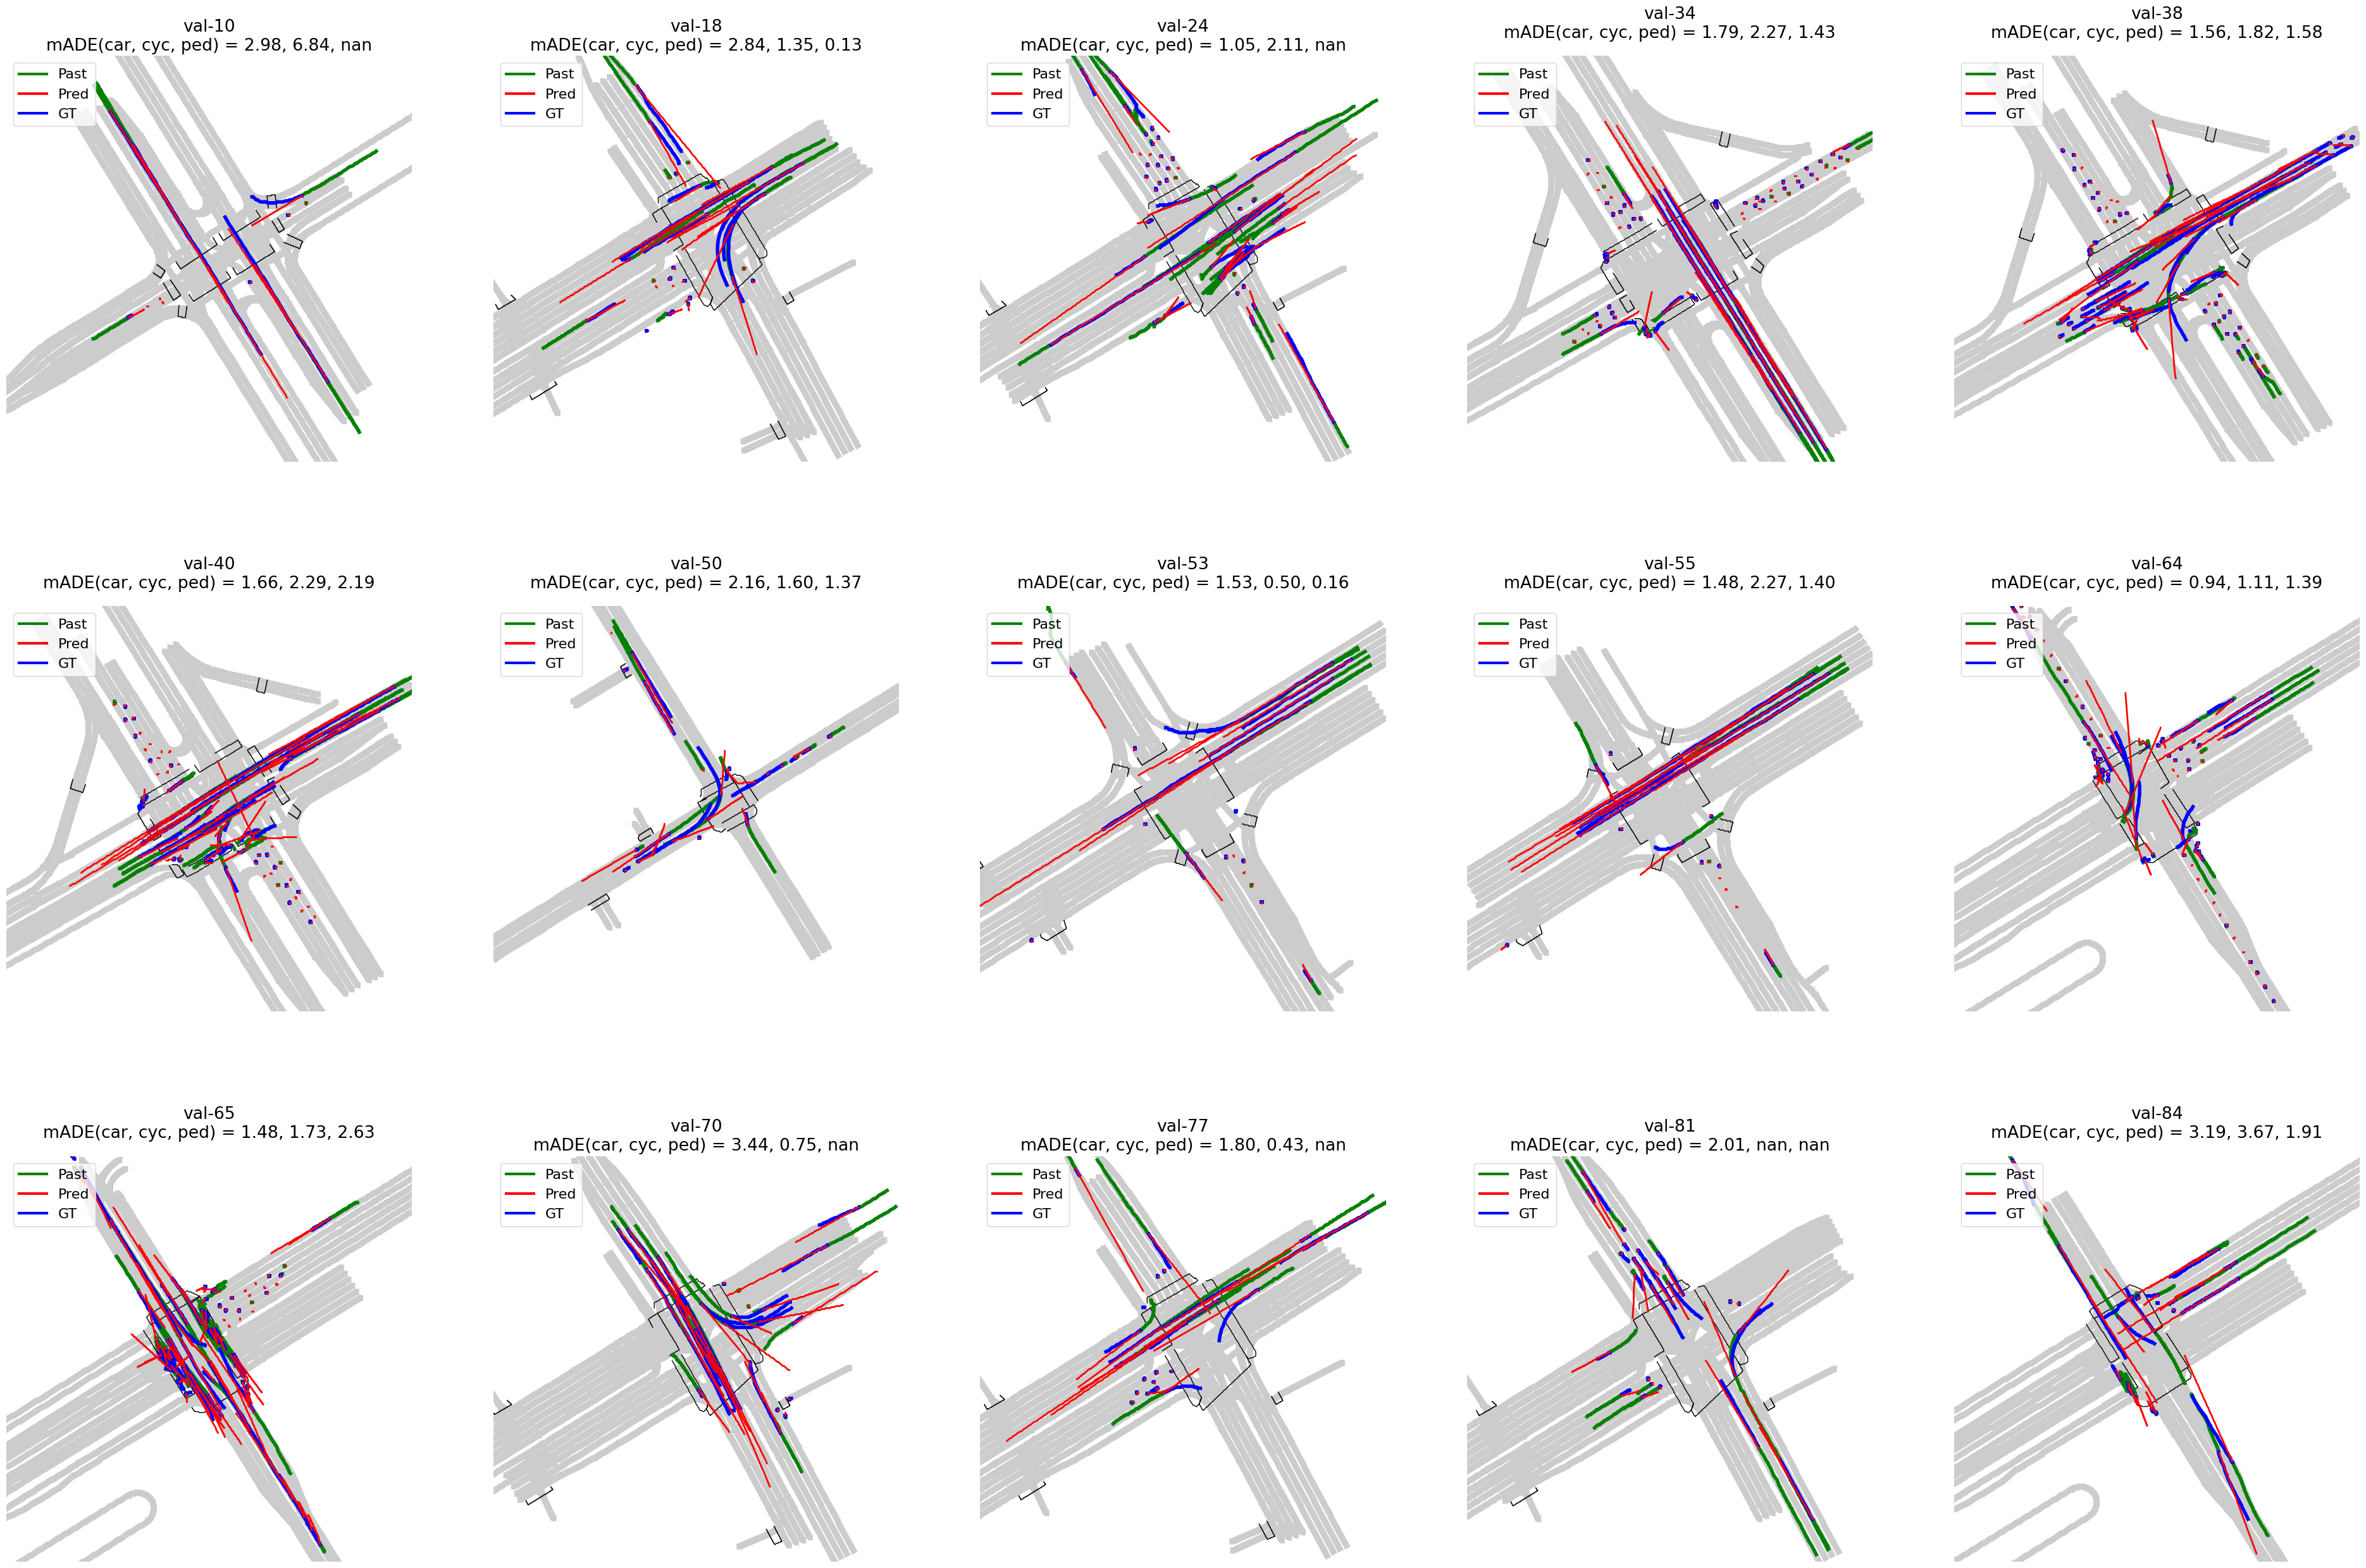

Max GPU Memory Allocated: 2.08 GB
Max GPU Memory Reserved: 5.90 GB


In [9]:
traj_paths = sorted(glob("{}/*.csv".format(path_to_traj)), key=lambda x: int(x.split('/')[-1].split('.')[0]))

map_fmt = path_to_maps+"/{}_hdmap{}.json"

plt.rcParams.update({'font.size': 16})

first_pos = {}

fig, axs = plt.subplots(3,5, figsize=(48, 32))
axs = axs.flatten()
ii = 0
for i in tqdm(range(len(traj_paths))[:15]):

    traj_path = traj_paths[i]
    df = pd.read_csv(traj_path)
    t = np.array(sorted(list(set(df['timestamp'].values))))
    
    map_path = map_fmt.format(df['intersect_id'][0].split('#')[0], df['intersect_id'][0].split('#')[1].split('-')[0])
    map_api = Map(map_path)

    # lanes = map_api.get_lanes_within(agent_xy, max_dist=100.0)
    # for lane in lanes.values():
    #     map_api.candidate_anchor_seqs[lane['id']] = map_api.get_candidate_anchors(lane)

    ade = {'vehicle':[], 'pedestrian':[], 'cyclist':[]}
    for j in range(0, 1):#max(1,len(t)-110-1)):

        agent_features = map_api.get_agent_features(df, j, 50)
        agent_xy = np.median(agent_features['position'][:,:,:2].cpu().numpy().reshape(-1,2),axis=0)
        map_features = map_api.get_map_features(agent_xy)

        # Plot map
        polygons = map_api.get_polygons_within(agent_xy, max_dist=100.0)        
        for polygon,polygon_type in polygons.values():
            if polygon_type == 'crosswalk':
                color = (0,0,0)
                linewidth = 1
                zorder=1
            else:
                color = (0.8,0.8,0.8)
                linewidth = 7
                zorder=0
            axs[ii].plot(polygon[:,0], polygon[:,1], color=color, zorder=zorder, linewidth=linewidth)

        
        # Compute prediction
        past_data = HeteroData({**{'agent': agent_features}, **map_features})
        future_data = HeteroData({**{'agent': map_api.get_agent_features(df, j+50, 60)}, **map_features})

        traj, pi, pred = qcnet_pred(net, past_data)

        past_position = past_data['agent']['position'][:,50-1,:2].cpu().numpy()
        past_velocity = past_data['agent']['velocity'][:,50-5:50-1,:2].cpu().numpy()
        past_velocity = np.median(past_velocity, axis=1)

        trajs_constant = predict_positions(past_position, past_velocity, total_time=6, frequency=10)

        for k in range(len(traj)):
        
            # Use constant velocity if QCNet prediction diverges too much from constant velocity prediction
            if np.median(np.linalg.norm(traj[k] - trajs_constant[k]) > 300):
                for l in range(len(traj[k])):
                    traj[k,l] = trajs_constant[k]

            # Use constant velocity for pedestrians and cyclist
            if past_data['agent']['type'][k] == 1 or past_data['agent']['type'][k] == 3:
                traj[k] = trajs_constant[k]
            
            # # For vehicles
            # if past_data['agent']['type'][k] == 0 or past_data['agent']['type'][k] == 2:

            #     if past_data['agent']['id'][k] not in first_pos:
            #         first_pos[past_data['agent']['id'][k]] = past_data['agent']['position'][k,:,:2].cpu().numpy().copy()
                
            #     centerlines = map_api.compute_anchors(first_pos[past_data['agent']['id'][k]][20:])

            #     if len(centerlines) > 0:
            #         centerlines = centerlines[:,0]
            #         for l in range(len(traj[k])):
                        
            #             idx = np.argmin([average_distance_to_polyline(traj[k,l], centerline) for centerline in centerlines])
            #             traj0 = map_trajectory_to_closest_centerline(traj[k,l], centerlines[idx][None])
            #             heading = np.arctan2(traj0[1,1]-traj0[0,1], traj0[1,0]-traj0[0,0])
                        
            #             if np.median(np.linalg.norm(traj[k,l] - traj0) < 300) and map_api.polyline_length(traj0) > 5:
            #                 traj[k,l] = traj0

            #             #traj1 = spline_controller(traj0[None], past_position[k][0], past_position[k][1], heading, smoothing_condition=5, forward_distance=0, idx=1)[0]
            #             # if np.median(np.linalg.norm(traj[k,l] - traj1) < 300) and map_api.polyline_length(traj0) > 5:
            #             #     traj1 = map_trajectory_to_closest_centerline(traj[k,l], traj1[None])
            #             #     traj[k,l] = traj1



        for k in range(len(pi)):
            agent_id = past_data['agent']['id'][k]
            if agent_id in future_data['agent']['id']:
                
                agent_idx_future = future_data['agent']['id'].index(agent_id)

                past_x = past_data['agent']['position'][k,:,0].cpu().numpy()
                past_y = past_data['agent']['position'][k,:,1].cpu().numpy()
                future_x = future_data['agent']['position'][agent_idx_future,:,0].numpy()
                future_y = future_data['agent']['position'][agent_idx_future,:,1].numpy()
                
                mask_past = np.logical_or(past_x != 0, past_y != 0)
                past_x = past_x[mask_past]
                past_y = past_y[mask_past]
                mask_future = np.logical_or(future_x != 0, future_y != 0)
                future_x = future_x[mask_future]
                future_y = future_y[mask_future]                
                
                dist = np.mean(np.linalg.norm(traj[k] - future_data['agent']['position'][agent_idx_future,:,:2].numpy()[None], axis=2)[:,mask_future],axis=1)
                pidx = np.argmin(dist)

                ade[map_api._agent_types[past_data['agent']['type'][k]]].append(dist[pidx])                

                axs[ii].plot(traj[k,pidx,:,0], traj[k,pidx,:,1], 'r', zorder=5, linewidth=2)
                axs[ii].plot(future_x, future_y, 'b', zorder=4, linewidth=4)
                axs[ii].plot(past_x, past_y, 'g', zorder=3, linewidth=4)
                

    ade['vehicle'] = np.nan if len(ade['vehicle']) == 0 else np.mean(ade['vehicle'])
    ade['pedestrian'] = np.nan if len(ade['pedestrian']) == 0 else np.mean(ade['pedestrian'])
    ade['cyclist'] = np.nan if len(ade['cyclist']) == 0 else np.mean(ade['cyclist'])

    axs[ii].axis('scaled')
    colors = ['g', 'r', 'b']
    lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
    labels = ['Past', 'Pred', 'GT']
    axs[ii].legend(lines, labels, loc="upper left")
    axs[ii].title.set_text('{}\nmADE(car, cyc, ped) = {:.2f}, {:.2f}, {:.2f}'.format('-'.join(traj_path.split('/')[-2:]).split('.')[0], ade['vehicle'], ade['cyclist'], ade['pedestrian']))
    axs[ii].axis('off')

    polygons = np.stack([v[0] for v in polygons.values()],axis=0).reshape(-1,2)
    x_mid = np.median(polygons[:,0])
    y_mid = np.median(polygons[:,1])
    plt_size = 200
    axs[ii].set_xlim([x_mid - plt_size//2, x_mid + plt_size//2])
    axs[ii].set_ylim([y_mid - plt_size//2, y_mid + plt_size//2])

    ii += 1
plt.show()


print(f"Max GPU Memory Allocated: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")
print(f"Max GPU Memory Reserved: {torch.cuda.max_memory_reserved() / 1e9:.2f} GB")